## Setup and Imports


In [161]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

# Global font settings for figures
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "font.family": "serif",
    "font.serif": ["Times New Roman"], # Try to use Times New Roman font
    "font.size": 12,                   # Base font size (adjust if needed)
    "axes.titlesize": 14,              # Axis title font size
    "axes.labelsize": 12,              # Axis label font size (x, y)
    "xtick.labelsize": 11,             # Tick label size on x axis
    "ytick.labelsize": 11,             # Tick label size on y axis
    "legend.fontsize": 11,
    "figure.titlesize": 16
})

### Constants


In [162]:
SEM_THRESHOLD = 0.65
STR_MIN_FILTER = 0.15

## Utility functions (normalization, DK, correctness)


In [163]:
def normalize_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = s.lower()
    s = re.sub(r"[^a-z0-9 ]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def is_dont_know(ans: str) -> bool:
    if pd.isna(ans):
        return False
    a = ans.lower()
    return "i don't know" in a or "i dont know" in a

def lexical_match(gold: str, pred: str) -> bool:
    g = normalize_text(gold)
    p = normalize_text(pred)
    if not g or not p:
        return False
    return g in p or p in g

def assign_constraint(row) -> str:
    return "constrained" if row["toxic_latency"] > 0 else "unconstrained"

def compute_correctness_flags(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["is_dk"] = df["answer_received"].apply(is_dont_know)

    df["lexical_match"] = df.apply(
        lambda r: lexical_match(r["answer_actual"], r["answer_received"]),
        axis=1
    )
    
    df["is_correct"] = df.apply(
        lambda r: (
            False if r["is_dk"] else
            (r["lexical_match"] or (
                r["similarity_semantic"] >= SEM_THRESHOLD and
                r["similarity_string"] >= STR_MIN_FILTER
            ))
        ),
        axis=1
    )
    return df


## Threshold Tuning - Sample Analysis


In [164]:
# Load QA datasets
qa_files = {
    "graphiti_constrained": "results/graphiti_conv_0_qa_constrained.csv",
    "graphiti_unconstrained": "results/graphiti_conv_0_qa.csv",
    "mem0_constrained": "results/mem0_conv_0_qa_constrained.csv",
    "mem0_unconstrained": "results/mem0_conv_0_qa.csv"
}

qa_data = {}
for name, path in qa_files.items():
    try:
        df = pd.read_csv(path)
        df["is_dk"] = df["answer_received"].apply(is_dont_know)
        df["lexical_match"] = df.apply(
            lambda r: lexical_match(r["answer_actual"], r["answer_received"]),
            axis=1
        )
        qa_data[name] = df
        print(f"✓ Loaded {name}: {len(df)} questions")
    except FileNotFoundError:
        print(f"✗ File not found: {path}")

print(f"\nTotal datasets loaded: {len(qa_data)}")


✓ Loaded graphiti_constrained: 199 questions
✓ Loaded graphiti_unconstrained: 199 questions
✓ Loaded mem0_constrained: 199 questions
✓ Loaded mem0_unconstrained: 199 questions

Total datasets loaded: 4


In [165]:
def display_sample_questions(df, dataset_name, n_samples=5, random_seed=42):
    """Display sample questions with all metrics for threshold tuning"""
    print(f"\n{'='*100}")
    print(f"📊 DATASET: {dataset_name.upper()}")
    print(f"{'='*100}\n")
    
    # Sample questions (mix of different similarity scores for better tuning)
    sample = df.sample(n=min(n_samples, len(df)), random_state=random_seed)
    
    for idx, (i, row) in enumerate(sample.iterrows(), 1):
        print(f"🔹 Question {idx}/{n_samples}")
        print(f"   Question: {row['question']}")
        print(f"\n   ✓ Expected:  {row['answer_actual']}")
        print(f"   → Received:  {row['answer_received']}")
        print(f"\n   📈 Scores:")
        print(f"      • Semantic Similarity:  {row['similarity_semantic']:.4f}")
        print(f"      • String Similarity:    {row['similarity_string']:.4f}")
        print(f"      • Average Similarity:   {row['similarity']:.4f}")
        print(f"      • Lexical Match:        {row['lexical_match']}")
        print(f"      • Is 'Don't Know':      {row['is_dk']}")
        print(f"\n   🎯 Classification (SEM≥{SEM_THRESHOLD}, STR≥{STR_MIN_FILTER}):")
        
        # Apply current thresholds
        is_correct = (
            False if row['is_dk'] else
            (row['lexical_match'] or (
                row['similarity_semantic'] >= SEM_THRESHOLD and
                row['similarity_string'] >= STR_MIN_FILTER
            ))
        )
        print(f"      → CORRECT: {'✓ YES' if is_correct else '✗ NO'}")
        print(f"\n   {'-'*96}\n")

# Display samples from each dataset
for name, df in qa_data.items():
    display_sample_questions(df, name, n_samples=5)



📊 DATASET: GRAPHITI_CONSTRAINED

🔹 Question 1/5
   Question: What did the charity race raise awareness for?

   ✓ Expected:  mental health
   → Received:  The charity race raised awareness for mental health awareness.

   📈 Scores:
      • Semantic Similarity:  0.5632
      • String Similarity:    0.3467
      • Average Similarity:   0.4549
      • Lexical Match:        True
      • Is 'Don't Know':      False

   🎯 Classification (SEM≥0.65, STR≥0.15):
      → CORRECT: ✓ YES

   ------------------------------------------------------------------------------------------------

🔹 Question 2/5
   Question: What activities does Melanie partake in?

   ✓ Expected:  pottery, camping, painting, swimming
   → Received:  Melanie partakes in running, reading, and playing violin, as she carves out me-time each day for these activities.

   📈 Scores:
      • Semantic Similarity:  0.2020
      • String Similarity:    0.2400
      • Average Similarity:   0.2210
      • Lexical Match:        False
  

### Focus on Borderline Cases (for fine-tuning thresholds)


In [166]:
def show_borderline_cases(df, dataset_name, threshold_margin=0.1, n_cases=5):
    """Show cases near the threshold boundaries - most useful for tuning"""
    print(f"\n{'='*100}")
    print(f"🎯 BORDERLINE CASES: {dataset_name.upper()}")
    print(f"   (Cases within ±{threshold_margin} of thresholds)")
    print(f"{'='*100}\n")
    
    # Find cases near semantic threshold
    near_sem_threshold = df[
        (df['similarity_semantic'] >= SEM_THRESHOLD - threshold_margin) &
        (df['similarity_semantic'] <= SEM_THRESHOLD + threshold_margin) &
        (~df['is_dk']) &
        (~df['lexical_match'])
    ].copy()
    
    if len(near_sem_threshold) > 0:
        print(f"📍 Cases near SEMANTIC threshold ({SEM_THRESHOLD}):")
        print(f"   Found {len(near_sem_threshold)} cases\n")
        
        sample = near_sem_threshold.head(n_cases)
        for idx, (i, row) in enumerate(sample.iterrows(), 1):
            print(f"   {idx}. [SEM={row['similarity_semantic']:.4f}, STR={row['similarity_string']:.4f}]")
            print(f"      Q: {row['question'][:80]}...")
            print(f"      Expected:  {row['answer_actual'][:60]}...")
            print(f"      Received:  {row['answer_received'][:60]}...")
            
            is_correct = (row['similarity_semantic'] >= SEM_THRESHOLD and 
                         row['similarity_string'] >= STR_MIN_FILTER)
            print(f"      → Status: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}\n")
    else:
        print(f"   No borderline cases found near semantic threshold\n")
    
    # Find cases near string minimum filter
    near_str_threshold = df[
        (df['similarity_string'] >= STR_MIN_FILTER - threshold_margin) &
        (df['similarity_string'] <= STR_MIN_FILTER + threshold_margin) &
        (df['similarity_semantic'] >= SEM_THRESHOLD) &
        (~df['is_dk']) &
        (~df['lexical_match'])
    ].copy()
    
    if len(near_str_threshold) > 0:
        print(f"\n📍 Cases near STRING filter ({STR_MIN_FILTER}):")
        print(f"   Found {len(near_str_threshold)} cases\n")
        
        sample = near_str_threshold.head(n_cases)
        for idx, (i, row) in enumerate(sample.iterrows(), 1):
            print(f"   {idx}. [SEM={row['similarity_semantic']:.4f}, STR={row['similarity_string']:.4f}]")
            print(f"      Q: {row['question'][:80]}...")
            print(f"      Expected:  {row['answer_actual'][:60]}...")
            print(f"      Received:  {row['answer_received'][:60]}...")
            
            is_correct = (row['similarity_semantic'] >= SEM_THRESHOLD and 
                         row['similarity_string'] >= STR_MIN_FILTER)
            print(f"      → Status: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}\n")
    else:
        print(f"   No borderline cases found near string filter\n")
    
    print(f"   {'-'*96}\n")

# Show borderline cases for each dataset
for name, df in qa_data.items():
    show_borderline_cases(df, name, threshold_margin=0.1, n_cases=3)



🎯 BORDERLINE CASES: GRAPHITI_CONSTRAINED
   (Cases within ±0.1 of thresholds)

📍 Cases near SEMANTIC threshold (0.65):
   Found 7 cases

   1. [SEM=0.6448, STR=0.3951]
      Q: What does Melanie do to destress?...
      Expected:  Running, pottery...
      Received:  Melanie destresses by running, painting, and engaging in pot...
      → Status: ✗ INCORRECT

   2. [SEM=0.5914, STR=0.2553]
      Q: What are Melanie's pets' names?...
      Expected:  Oliver, Luna, Bailey...
      Received:  Melanie has a cat named Bailey, a cat named Oliver, and a do...
      → Status: ✗ INCORRECT

   3. [SEM=0.6559, STR=0.3478]
      Q: What instruments does Melanie play?...
      Expected:  clarinet and violin...
      Received:  Melanie plays the clarinet....
      → Status: ✓ CORRECT

   No borderline cases found near string filter

   ------------------------------------------------------------------------------------------------


🎯 BORDERLINE CASES: GRAPHITI_UNCONSTRAINED
   (Cases within ±0.1 of

### Score Distribution Summary


In [167]:
def print_score_summary(df, dataset_name):
    """Print statistical summary of scores for threshold tuning"""
    print(f"\n📊 {dataset_name.upper()}")
    print(f"   Total questions: {len(df)}")
    print(f"\n   Semantic Similarity:")
    print(f"      Mean:   {df['similarity_semantic'].mean():.4f}")
    print(f"      Median: {df['similarity_semantic'].median():.4f}")
    print(f"      Std:    {df['similarity_semantic'].std():.4f}")
    print(f"      Min:    {df['similarity_semantic'].min():.4f}")
    print(f"      Max:    {df['similarity_semantic'].max():.4f}")
    print(f"      ≥{SEM_THRESHOLD}: {(df['similarity_semantic'] >= SEM_THRESHOLD).sum()} ({(df['similarity_semantic'] >= SEM_THRESHOLD).sum()/len(df)*100:.1f}%)")
    
    print(f"\n   String Similarity:")
    print(f"      Mean:   {df['similarity_string'].mean():.4f}")
    print(f"      Median: {df['similarity_string'].median():.4f}")
    print(f"      Std:    {df['similarity_string'].std():.4f}")
    print(f"      Min:    {df['similarity_string'].min():.4f}")
    print(f"      Max:    {df['similarity_string'].max():.4f}")
    print(f"      ≥{STR_MIN_FILTER}: {(df['similarity_string'] >= STR_MIN_FILTER).sum()} ({(df['similarity_string'] >= STR_MIN_FILTER).sum()/len(df)*100:.1f}%)")
    
    print(f"\n   Flags:")
    print(f"      Lexical Match:  {df['lexical_match'].sum()} ({df['lexical_match'].sum()/len(df)*100:.1f}%)")
    print(f"      'Don't Know':   {df['is_dk'].sum()} ({df['is_dk'].sum()/len(df)*100:.1f}%)")
    
    # Calculate with current thresholds
    df_temp = df.copy()
    df_temp['is_correct'] = df_temp.apply(
        lambda r: (
            False if r['is_dk'] else
            (r['lexical_match'] or (
                r['similarity_semantic'] >= SEM_THRESHOLD and
                r['similarity_string'] >= STR_MIN_FILTER
            ))
        ),
        axis=1
    )
    print(f"\n   ✓ Correct (with SEM≥{SEM_THRESHOLD}, STR≥{STR_MIN_FILTER}): {df_temp['is_correct'].sum()} ({df_temp['is_correct'].sum()/len(df)*100:.1f}%)")
    print(f"   {'-'*60}\n")

print(f"\n{'='*100}")
print(f"SCORE DISTRIBUTION SUMMARY")
print(f"{'='*100}")

for name, df in qa_data.items():
    print_score_summary(df, name)



SCORE DISTRIBUTION SUMMARY

📊 GRAPHITI_CONSTRAINED
   Total questions: 199

   Semantic Similarity:
      Mean:   0.2101
      Median: 0.1623
      Std:    0.1800
      Min:    -0.0277
      Max:    0.7541
      ≥0.65: 6 (3.0%)

   String Similarity:
      Mean:   0.2372
      Median: 0.2430
      Std:    0.1297
      Min:    0.0000
      Max:    0.7684
      ≥0.15: 153 (76.9%)

   Flags:
      Lexical Match:  16 (8.0%)
      'Don't Know':   133 (66.8%)

   ✓ Correct (with SEM≥0.65, STR≥0.15): 16 (8.0%)
   ------------------------------------------------------------


📊 GRAPHITI_UNCONSTRAINED
   Total questions: 199

   Semantic Similarity:
      Mean:   0.2568
      Median: 0.1872
      Std:    0.2072
      Min:    -0.0277
      Max:    0.9391
      ≥0.65: 10 (5.0%)

   String Similarity:
      Mean:   0.2452
      Median: 0.2353
      Std:    0.1482
      Min:    0.0000
      Max:    0.9231
      ≥0.15: 150 (75.4%)

   Flags:
      Lexical Match:  21 (10.6%)
      'Don't Know':   11

### Interactive Threshold Testing


In [168]:
def test_thresholds(df, dataset_name, sem_threshold, str_min_filter):
    """Test different threshold values and show results"""
    df_temp = df.copy()
    
    df_temp['is_correct'] = df_temp.apply(
        lambda r: (
            False if r['is_dk'] else
            (r['lexical_match'] or (
                r['similarity_semantic'] >= sem_threshold and
                r['similarity_string'] >= str_min_filter
            ))
        ),
        axis=1
    )
    
    correct_count = df_temp['is_correct'].sum()
    total = len(df_temp)
    percentage = (correct_count / total * 100) if total > 0 else 0
    
    print(f"   {dataset_name:25s} → {correct_count:3d}/{total:3d} correct ({percentage:5.1f}%)")
    return correct_count, total

print(f"\n{'='*100}")
print(f"THRESHOLD TESTING - Compare different threshold combinations")
print(f"{'='*100}\n")

# Test different threshold combinations
threshold_combinations = [
    (0.60, 0.10),
    (0.65, 0.15),  # Current
    (0.70, 0.15),
    (0.65, 0.20),
    (0.70, 0.20),
]

for sem_thresh, str_thresh in threshold_combinations:
    print(f"\n🎯 Testing: SEM_THRESHOLD={sem_thresh}, STR_MIN_FILTER={str_thresh}")
    print(f"   {'-'*96}")
    
    total_correct = 0
    total_questions = 0
    
    for name, df in qa_data.items():
        correct, total = test_thresholds(df, name, sem_thresh, str_thresh)
        total_correct += correct
        total_questions += total
    
    overall_pct = (total_correct / total_questions * 100) if total_questions > 0 else 0
    print(f"   {'-'*96}")
    print(f"   {'OVERALL':25s} → {total_correct:3d}/{total_questions:3d} correct ({overall_pct:5.1f}%)")

print(f"\n{'='*100}\n")



THRESHOLD TESTING - Compare different threshold combinations


🎯 Testing: SEM_THRESHOLD=0.6, STR_MIN_FILTER=0.1
   ------------------------------------------------------------------------------------------------
   graphiti_constrained      →  17/199 correct (  8.5%)
   graphiti_unconstrained    →  24/199 correct ( 12.1%)
   mem0_constrained          →  13/199 correct (  6.5%)
   mem0_unconstrained        →  15/199 correct (  7.5%)
   ------------------------------------------------------------------------------------------------
   OVERALL                   →  69/796 correct (  8.7%)

🎯 Testing: SEM_THRESHOLD=0.65, STR_MIN_FILTER=0.15
   ------------------------------------------------------------------------------------------------
   graphiti_constrained      →  16/199 correct (  8.0%)
   graphiti_unconstrained    →  22/199 correct ( 11.1%)
   mem0_constrained          →  12/199 correct (  6.0%)
   mem0_unconstrained        →  15/199 correct (  7.5%)
   ----------------------------

# QA Processing


## Load all QA


In [169]:
def load_qa_csv(path: str, system: str, constraint: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["system"] = system
    df["constraint_profile"] = constraint
    
    # Correct inflated metrics by dividing by metric_window_s
    metrics_to_correct = [
        "cpu_edge_ns", "cpu_cloud_ns",
        "ram_edge_bytes", "ram_cloud_bytes",
        "disk_edge_bytes", "disk_cloud_bytes",
        "network_edge_bytes", "network_cloud_bytes"
    ]
    for col in metrics_to_correct:
        df[col] = df[col] / df["metric_window_s"]
    
    return df


qa_parts = []

qa_parts.append(load_qa_csv(
    "results/graphiti_conv_0_qa_constrained.csv", system="graphiti", constraint="constrained"
))
qa_parts.append(load_qa_csv(
    "results/graphiti_conv_0_qa.csv", system="graphiti", constraint="unconstrained"
))
qa_parts.append(load_qa_csv(
    "results/mem0_conv_0_qa_constrained.csv", system="mem0", constraint="constrained"
))
qa_parts.append(load_qa_csv(
    "results/mem0_conv_0_qa.csv", system="mem0", constraint="unconstrained"
))

qa_df = pd.concat(qa_parts, ignore_index=True)
qa_df.head()


,memory,time,conversation_index,question,answer_actual,answer_received,similarity_string,similarity_semantic,similarity,cpu_edge_ns,...,toxic_latency,toxic_jitter,toxic_bandwidth,toxic_slow_close,toxic_timeout,toxic_slicer,toxic_limit_data,toxic_reset_peer,system,constraint_profile
0,graphiti,1.763657e+09,0,When did Caroline go to the LGBTQ support group?,7 May 2023,Caroline went to an LGBTQ support group on May...,0.206897,0.445800,0.326348,5.708914e+10,...,200,50,1000,0,0,0,0,0,graphiti,constrained
1,graphiti,1.763657e+09,0,When did Melanie paint a sunrise?,2022,I don't know based on the given memories.,0.000000,0.165528,0.082764,1.339592e+09,...,200,50,1000,0,0,0,0,0,graphiti,constrained
2,graphiti,1.763657e+09,0,What fields would Caroline be likely to pursue...,"Psychology, counseling certification",Caroline would likely pursue fields related to...,0.281081,0.476308,0.378695,3.001876e+09,...,200,50,1000,0,0,0,0,0,graphiti,constrained
3,graphiti,1.763658e+09,0,What did Caroline research?,Adoption agencies,I don't know based on the given memories.,0.413793,0.045285,0.229539,2.192776e+09,...,200,50,1000,0,0,0,0,0,graphiti,constrained
4,graphiti,1.763658e+09,0,What is Caroline's identity?,Transgender woman,I don't know based on the given memories.,0.275862,0.148438,0.212150,1.850005e+09,...,200,50,1000,0,0,0,0,0,graphiti,constrained


In [170]:
qa_df.keys()

Index(['memory', 'time', 'conversation_index', 'question', 'answer_actual',
       'answer_received', 'similarity_string', 'similarity_semantic',
       'similarity', 'cpu_edge_ns', 'cpu_cloud_ns', 'ram_edge_bytes',
       'ram_cloud_bytes', 'disk_edge_bytes', 'disk_cloud_bytes',
       'network_edge_bytes', 'network_cloud_bytes', 'openai_tokens',
       'openai_cost_usd', 'api_latency_s', 'metric_window_s', 'toxic_latency',
       'toxic_jitter', 'toxic_bandwidth', 'toxic_slow_close', 'toxic_timeout',
       'toxic_slicer', 'toxic_limit_data', 'toxic_reset_peer', 'system',
       'constraint_profile'],
      dtype='object')

Compute Flags


In [171]:
qa_df = compute_correctness_flags(qa_df)

## QA aggregation


In [172]:
group_cols = ["system", "constraint_profile"]

agg_qa = qa_df.groupby(group_cols).agg(
    N=("question", "count"),
    N_correct=("is_correct", "sum"),
    N_dk=("is_dk", "sum"),
    tokens_mean=("openai_tokens", "mean"),
    cost_mean=("openai_cost_usd", "mean"),
    latency_mean=("api_latency_s", "mean"),
).reset_index()

agg_qa["N_wrong"] = agg_qa["N"] - agg_qa["N_correct"] - agg_qa["N_dk"]
agg_qa["acc"] = agg_qa["N_correct"] / agg_qa["N"]
agg_qa["dk_rate"] = agg_qa["N_dk"] / agg_qa["N"]
agg_qa["ans_rate"] = 1 - agg_qa["dk_rate"]
agg_qa["cost_of_pass"] = agg_qa["tokens_mean"] / agg_qa["acc"]


# Sessions Processing


## Load session CSVs and aggregate


In [173]:
def load_sessions_csv(path: str, system: str, constraint: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["system"] = system
    df["constraint_profile"] = constraint
    
    # Correct inflated metrics by dividing by metric_window_s
    metrics_to_correct = [
        "cpu_edge_ns", "cpu_cloud_ns",
        "ram_edge_bytes", "ram_cloud_bytes",
        "disk_edge_bytes", "disk_cloud_bytes",
        "network_edge_bytes", "network_cloud_bytes"
    ]
    for col in metrics_to_correct:
        df[col] = df[col] / df["metric_window_s"]
    
    return df

sessions_parts = []
sessions_parts.append(load_sessions_csv(
    "results/graphiti_conv_0_sessions_constrained.csv", "graphiti", "constrained"
))
sessions_parts.append(load_sessions_csv(
    "results/graphiti_conv_0_sessions.csv", "graphiti", "unconstrained"
))
sessions_parts.append(load_sessions_csv(
    "results/mem0_conv_0_sessions_constrained.csv", "mem0", "constrained"
))
sessions_parts.append(load_sessions_csv(
    "results/mem0_conv_0_sessions.csv", "mem0", "unconstrained"
))

sessions_df = pd.concat(sessions_parts, ignore_index=True)

agg_sessions = sessions_df.groupby(["system", "constraint_profile"]).agg(
    N_sessions=("session_id", "count"),
    tokens_per_session=("openai_tokens", "mean"),
    cost_per_session=("openai_cost_usd", "mean"),
    latency_per_session=("api_latency_s", "mean")
).reset_index()

sessions_df.head()

,memory,time,conversation_index,session_id,cpu_edge_ns,cpu_cloud_ns,ram_edge_bytes,ram_cloud_bytes,disk_edge_bytes,disk_cloud_bytes,...,toxic_latency,toxic_jitter,toxic_bandwidth,toxic_slow_close,toxic_timeout,toxic_slicer,toxic_limit_data,toxic_reset_peer,system,constraint_profile
0,graphiti,1.763919e+09,0,1,2.050968e+09,2.683167e+10,2.063344e+08,1.810327e+09,0.000000,2.947848e+06,...,200,50,1000,0,0,0,0,0,graphiti,constrained
1,graphiti,1.763919e+09,0,2,2.894913e+09,2.568337e+10,1.163336e+08,1.300892e+09,0.000000,2.244372e+06,...,200,50,1000,0,0,0,0,0,graphiti,constrained
2,graphiti,1.763920e+09,0,3,4.289142e+09,2.461200e+10,1.075728e+08,1.262417e+09,61238.557377,2.545442e+06,...,200,50,1000,0,0,0,0,0,graphiti,constrained
3,graphiti,1.763920e+09,0,4,3.216514e+09,1.635066e+10,1.120501e+08,1.296436e+09,52833.797753,2.618025e+06,...,200,50,1000,0,0,0,0,0,graphiti,constrained
4,graphiti,1.763921e+09,0,5,2.794676e+09,1.366685e+10,1.192316e+08,1.324409e+09,9505.221374,1.821730e+06,...,200,50,1000,0,0,0,0,0,graphiti,constrained


# ---------------------------------------------


# Variables and helper functions


In [174]:
# =============================================================================
# METRIC CONFIGURATION
# =============================================================================
# Define all metrics with their aggregation, conversion, and display settings

METRIC_CONFIG = {
    # Computational Resources
    "cpu_cloud_ns": {
        "agg": "sum",
        "label": "CPU Cloud",
        "unit": "min",
        "conversion": lambda x: x / 1e9 / 60,  # ns -> minutes
        "decimals": 1
    },
    "cpu_edge_ns": {
        "agg": "sum",
        "label": "CPU Edge",
        "unit": "min",
        "conversion": lambda x: x / 1e9 / 60,
        "decimals": 1
    },
    "ram_cloud_bytes": {
        "agg": "max",
        "label": "RAM Cloud",
        "unit": "MB",
        "conversion": lambda x: x / 1024**2,
        "decimals": 1
    },
    "ram_edge_bytes": {
        "agg": "max",
        "label": "RAM Edge",
        "unit": "MB",
        "conversion": lambda x: x / 1024**2,
        "decimals": 1
    },
    "disk_cloud_bytes": {
        "agg": "sum",
        "label": "Disk Cloud",
        "unit": "MB",
        "conversion": lambda x: x / 1024**2,
        "decimals": 1
    },
    "disk_edge_bytes": {
        "agg": "sum",
        "label": "Disk Edge",
        "unit": "MB",
        "conversion": lambda x: x / 1024**2,
        "decimals": 1
    },
    "network_cloud_bytes": {
        "agg": "sum",
        "label": "Net Cloud",
        "unit": "MB",
        "conversion": lambda x: x / 1024**2,
        "decimals": 1
    },
    "network_edge_bytes": {
        "agg": "sum",
        "label": "Net Edge",
        "unit": "MB",
        "conversion": lambda x: x / 1024**2,
        "decimals": 1
    },
    
    # Financial
    "openai_tokens": {
        "agg": "sum",
        "label": "Total Tokens",
        "unit": "k",
        "conversion": lambda x: x / 1000,
        "decimals": 1
    },
    "openai_cost_usd": {
        "agg": "sum",
        "label": "Cost",
        "unit": "USD",
        "conversion": lambda x: x,
        "decimals": 4,
        "format": "${:.4f}"
    },
    
    # Temporal
    "api_latency_s": {
        "agg": "mean",
        "label": "Latency",
        "unit": "s",
        "conversion": lambda x: x,
        "decimals": 2
    },
    
    # Quality
    "similarity": {
        "agg": "mean",
        "label": "Similarity",
        "unit": "%",
        "conversion": lambda x: x * 100,
        "decimals": 1
    },
    "similarity_semantic": {
        "agg": "mean",
        "label": "Semantic Sim.",
        "unit": "%",
        "conversion": lambda x: x * 100,
        "decimals": 1
    },
    "similarity_string": {
        "agg": "mean",
        "label": "String Sim.",
        "unit": "%",
        "conversion": lambda x: x * 100,
        "decimals": 1
    },

    # Aggiungi a METRIC_CONFIG:

    # Quality / Retention
    "N": {
        "agg": "sum",
        "label": "Total Qs",
        "unit": "N",
        "conversion": lambda x: x,
        "decimals": 0
    },
    "N_correct": {
        "agg": "sum",
        "label": "Correct",
        "unit": "N",
        "conversion": lambda x: x,
        "decimals": 0
    },
    "N_wrong": {
        "agg": "sum",
        "label": "Incorrect",
        "unit": "N",
        "conversion": lambda x: x,
        "decimals": 0
    },
    "N_dk": {
        "agg": "sum",
        "label": "I Don't Know",
        "unit": "N",
        "conversion": lambda x: x,
        "decimals": 0
    },
    "acc": {
        "agg": "mean",
        "label": "Accuracy",
        "unit": "%",
        "conversion": lambda x: x * 100,
        "decimals": 1
    },
    "dk_rate": {
        "agg": "mean",
        "label": "DK Rate",
        "unit": "%",
        "conversion": lambda x: x * 100,
        "decimals": 1
    },
    "ans_rate": {
        "agg": "mean",
        "label": "Answer Rate",
        "unit": "%",
        "conversion": lambda x: x * 100,
        "decimals": 1
    },
}

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def build_table(df: pd.DataFrame, metrics: list, groupby: str = "system") -> pd.DataFrame:
    """
    Build a summary table from a DataFrame using the metric configuration.
    
    Args:
        df: Source DataFrame
        metrics: List of metric column names to include
        groupby: Column to group by (default: "system")
    
    Returns:
        Formatted DataFrame with converted units and proper labels
    """
    # Build aggregation dict
    agg_dict = {m: METRIC_CONFIG[m]["agg"] for m in metrics}
    
    # Aggregate
    summary = df.groupby(groupby).agg(agg_dict)
    
    # Convert and rename
    result = pd.DataFrame()
    for m in metrics:
        cfg = METRIC_CONFIG[m]
        col_name = f"{cfg['label']} ({cfg['unit']})"
        result[col_name] = cfg["conversion"](summary[m]).round(cfg["decimals"])
    
    result.index = result.index.str.capitalize()
    result.index.name = groupby.capitalize()
    
    return result


def build_table_multi_agg(df: pd.DataFrame, metric: str, aggs: list, groupby: str = "system") -> pd.DataFrame:
    """
    Build a table with multiple aggregations for a single metric (e.g., mean, median, std).
    
    Args:
        df: Source DataFrame
        metric: The metric column name
        aggs: List of aggregation functions (e.g., ["mean", "median", "std"])
        groupby: Column to group by
    
    Returns:
        Formatted DataFrame
    """
    cfg = METRIC_CONFIG[metric]
    
    summary = df.groupby(groupby)[metric].agg(aggs)
    
    result = pd.DataFrame()
    for agg in aggs:
        col_name = f"{agg.capitalize()} {cfg['label']} ({cfg['unit']})"
        result[col_name] = cfg["conversion"](summary[agg]).round(cfg["decimals"])
    
    result.index = result.index.str.capitalize()
    result.index.name = groupby.capitalize()
    
    return result

In [175]:
def format_aggregated_table(df: pd.DataFrame, metrics: list) -> pd.DataFrame:
    """
    Format an already-aggregated DataFrame using metric configuration.
    
    Args:
        df: Already aggregated DataFrame
        metrics: List of metric column names to include
    
    Returns:
        Formatted DataFrame with converted units and proper labels
    """
    result = pd.DataFrame(index=df.index)
    
    for m in metrics:
        cfg = METRIC_CONFIG[m]
        col_name = f"{cfg['label']} ({cfg['unit']})"
        result[col_name] = cfg["conversion"](df[m]).round(cfg["decimals"])
        
        # Format percentages with % symbol
        if cfg["unit"] == "%":
            result[col_name] = result[col_name].map('{:.1f}%'.format)
    
    result.index = result.index.str.capitalize()
    result.index.name = "System"
    
    return result

In [176]:
financial_metrics = ["openai_tokens", "openai_cost_usd"]
computational_metrics = [
    "cpu_cloud_ns", "cpu_edge_ns",
    "ram_cloud_bytes", "ram_edge_bytes",
    "disk_cloud_bytes", "disk_edge_bytes",
    "network_cloud_bytes", "network_edge_bytes"
]
retention_metrics = ["N", "N_correct", "N_wrong", "N_dk", "acc", "dk_rate", "ans_rate"]

# Uncostrainted


## Session Loading

> Graphiti vs Mem0


In [177]:
# Filter unconstrained only
unconstrained_sessions = sessions_df[sessions_df["constraint_profile"] == "unconstrained"]

In [178]:
unconstrained_sessions.keys()

Index(['memory', 'time', 'conversation_index', 'session_id', 'cpu_edge_ns',
       'cpu_cloud_ns', 'ram_edge_bytes', 'ram_cloud_bytes', 'disk_edge_bytes',
       'disk_cloud_bytes', 'network_edge_bytes', 'network_cloud_bytes',
       'openai_tokens', 'openai_cost_usd', 'api_latency_s', 'metric_window_s',
       'toxic_latency', 'toxic_jitter', 'toxic_bandwidth', 'toxic_slow_close',
       'toxic_timeout', 'toxic_slicer', 'toxic_limit_data', 'toxic_reset_peer',
       'system', 'constraint_profile'],
      dtype='object')

### Financial cost (token + cost in USD)


In [179]:
# Financial cost table
financial_table_unconstrained_sessions = build_table(unconstrained_sessions, financial_metrics)
financial_table_unconstrained_sessions

,Total Tokens (k),Cost (USD)
System,,
Graphiti,4948.5,0.0027
Mem0,1017.4,0.1319


### Computational cost

> RAM, CPU, Disk, Network


In [180]:
computational_table_unconstrained_sessions = build_table(unconstrained_sessions, computational_metrics)
computational_table_unconstrained_sessions.T

System,Graphiti,Mem0
CPU Cloud (min),17.1,2.4
CPU Edge (min),3.2,0.4
RAM Cloud (MB),1115.3,766.9
RAM Edge (MB),145.3,94.5
Disk Cloud (MB),76.0,11.8
Disk Edge (MB),0.0,0.0
Net Cloud (MB),1332.3,22.1
Net Edge (MB),71.1,1.7


In [181]:
# CPU: Total compute time → real cost (CPU hours)
# RAM: Peak usage (GB) → Peak memory provisioning
# Disk: Total I/O (GB) → Throughput (GB)
# Network: Total transfer → Bandwidth cost (GB)

### Temporal cost

> API Latency


In [182]:
# Latency table with multiple aggregations
latency_table_unconstrained_sessions = build_table_multi_agg(unconstrained_sessions, "api_latency_s", ["mean", "median", "std"])
latency_table_unconstrained_sessions

,Mean Latency (s),Median Latency (s),Std Latency (s)
System,,,
Graphiti,569.42,472.63,197.88
Mem0,76.83,72.29,19.27


## Question and Answers

> Graphiti vs Mem0


In [183]:
# Filter unconstrained only
unconstrained_qa = qa_df[qa_df["constraint_profile"] == "unconstrained"]
unconstrained_aggregated_qa = agg_qa[agg_qa["constraint_profile"] == "unconstrained"].set_index("system")

In [184]:
unconstrained_qa.keys()

Index(['memory', 'time', 'conversation_index', 'question', 'answer_actual',
       'answer_received', 'similarity_string', 'similarity_semantic',
       'similarity', 'cpu_edge_ns', 'cpu_cloud_ns', 'ram_edge_bytes',
       'ram_cloud_bytes', 'disk_edge_bytes', 'disk_cloud_bytes',
       'network_edge_bytes', 'network_cloud_bytes', 'openai_tokens',
       'openai_cost_usd', 'api_latency_s', 'metric_window_s', 'toxic_latency',
       'toxic_jitter', 'toxic_bandwidth', 'toxic_slow_close', 'toxic_timeout',
       'toxic_slicer', 'toxic_limit_data', 'toxic_reset_peer', 'system',
       'constraint_profile', 'is_dk', 'lexical_match', 'is_correct'],
      dtype='object')

In [185]:
unconstrained_aggregated_qa.keys()

Index(['constraint_profile', 'N', 'N_correct', 'N_dk', 'tokens_mean',
       'cost_mean', 'latency_mean', 'N_wrong', 'acc', 'dk_rate', 'ans_rate',
       'cost_of_pass'],
      dtype='object')

### Knowledge Retention

> Correct, incorrect, I don't know


In [186]:
# Knowledge Retention table
retention_table_unconstrained_qa = format_aggregated_table(unconstrained_aggregated_qa, retention_metrics)

retention_table_unconstrained_qa

,Total Qs (N),Correct (N),Incorrect (N),I Don't Know (N),Accuracy (%),DK Rate (%),Answer Rate (%)
System,,,,,,,
Graphiti,199,22,60,117,11.1%,58.8%,41.2%
Mem0,199,15,53,131,7.5%,65.8%,34.2%


### Financial cost (token + cost in USD)


In [187]:
# Financial cost table
financial_table_unconstrained_qa = build_table(unconstrained_qa, financial_metrics)
financial_table_unconstrained_qa

,Total Tokens (k),Cost (USD)
System,,
Graphiti,161.5,0.4287
Mem0,113.2,0.2822


### Computational cost

> RAM, CPU, Disk, Network


In [188]:
computational_table_unconstrained_qa = build_table(unconstrained_qa, computational_metrics)
computational_table_unconstrained_qa.T

System,Graphiti,Mem0
CPU Cloud (min),2.1,7.0
CPU Edge (min),10.1,3.6
RAM Cloud (MB),1221.2,918.3
RAM Edge (MB),2617.1,2463.8
Disk Cloud (MB),5.5,1.4
Disk Edge (MB),125.0,1122.9
Net Cloud (MB),97.4,0.3
Net Edge (MB),2.1,0.1


### Temporal cost


In [189]:
# Latency table with multiple aggregations
latency_table_unconstrained_qa = build_table_multi_agg(unconstrained_qa, "api_latency_s", ["mean", "median", "std"])
latency_table_unconstrained_qa

,Mean Latency (s),Median Latency (s),Std Latency (s)
System,,,
Graphiti,16.21,15.45,7.56
Mem0,13.84,13.22,3.40


#

---


# Constrainted


## Session Loading

> Graphiti vs Mem0


In [190]:
# Filter unconstrained only
constrained_sessions = sessions_df[sessions_df["constraint_profile"] == "constrained"]

In [191]:
constrained_sessions.keys()

Index(['memory', 'time', 'conversation_index', 'session_id', 'cpu_edge_ns',
       'cpu_cloud_ns', 'ram_edge_bytes', 'ram_cloud_bytes', 'disk_edge_bytes',
       'disk_cloud_bytes', 'network_edge_bytes', 'network_cloud_bytes',
       'openai_tokens', 'openai_cost_usd', 'api_latency_s', 'metric_window_s',
       'toxic_latency', 'toxic_jitter', 'toxic_bandwidth', 'toxic_slow_close',
       'toxic_timeout', 'toxic_slicer', 'toxic_limit_data', 'toxic_reset_peer',
       'system', 'constraint_profile'],
      dtype='object')

### Financial cost (token + cost in USD)


In [192]:
financial_table_constrained_sessions = build_table(constrained_sessions, financial_metrics)
financial_table_constrained_sessions

,Total Tokens (k),Cost (USD)
System,,
Graphiti,4956.7,0.0030
Mem0,1014.2,0.1319


### Computational cost

> RAM, CPU, Disk, Network


In [193]:
computational_table_constrained_sessions = build_table(constrained_sessions, computational_metrics)
computational_table_constrained_sessions.T

System,Graphiti,Mem0
CPU Cloud (min),6.2,3.3
CPU Edge (min),1.2,0.6
RAM Cloud (MB),1726.5,826.7
RAM Edge (MB),196.8,96.3
Disk Cloud (MB),84.4,10.5
Disk Edge (MB),0.1,0.1
Net Cloud (MB),1335.9,24.1
Net Edge (MB),87.7,1.9


### Temporal cost


In [194]:
latency_table_constrained_sessions = build_table_multi_agg(constrained_sessions, "api_latency_s", ["mean", "median", "std"])
latency_table_constrained_sessions

,Mean Latency (s),Median Latency (s),Std Latency (s)
System,,,
Graphiti,549.32,573.53,166.63
Mem0,94.76,76.89,57.24


## Question and Answers

> Graphiti vs Mem0


In [195]:
# Filter unconstrained only
constrained_qa = qa_df[qa_df["constraint_profile"] == "constrained"]
constrained_aggregated_qa = agg_qa[agg_qa["constraint_profile"] == "constrained"].set_index("system")

In [196]:
constrained_qa.keys()

Index(['memory', 'time', 'conversation_index', 'question', 'answer_actual',
       'answer_received', 'similarity_string', 'similarity_semantic',
       'similarity', 'cpu_edge_ns', 'cpu_cloud_ns', 'ram_edge_bytes',
       'ram_cloud_bytes', 'disk_edge_bytes', 'disk_cloud_bytes',
       'network_edge_bytes', 'network_cloud_bytes', 'openai_tokens',
       'openai_cost_usd', 'api_latency_s', 'metric_window_s', 'toxic_latency',
       'toxic_jitter', 'toxic_bandwidth', 'toxic_slow_close', 'toxic_timeout',
       'toxic_slicer', 'toxic_limit_data', 'toxic_reset_peer', 'system',
       'constraint_profile', 'is_dk', 'lexical_match', 'is_correct'],
      dtype='object')

In [197]:
constrained_aggregated_qa.keys()

Index(['constraint_profile', 'N', 'N_correct', 'N_dk', 'tokens_mean',
       'cost_mean', 'latency_mean', 'N_wrong', 'acc', 'dk_rate', 'ans_rate',
       'cost_of_pass'],
      dtype='object')

### Knowledge Retention

> Correct, incorrect, I don't know


In [198]:
retention_table_constrained_qa = format_aggregated_table(constrained_aggregated_qa, retention_metrics)

retention_table_constrained_qa

,Total Qs (N),Correct (N),Incorrect (N),I Don't Know (N),Accuracy (%),DK Rate (%),Answer Rate (%)
System,,,,,,,
Graphiti,199,16,50,133,8.0%,66.8%,33.2%
Mem0,199,12,51,136,6.0%,68.3%,31.7%


### Financial cost (token + cost in USD)


In [199]:
financial_table_constrained_qa = build_table(constrained_qa, financial_metrics)
financial_table_constrained_qa

,Total Tokens (k),Cost (USD)
System,,
Graphiti,112.5,0.2775
Mem0,113.4,0.2806


### Computational cost

> RAM, CPU, Disk, Network


In [200]:
computational_table_constrained_qa = build_table(constrained_qa, computational_metrics)
computational_table_constrained_qa.T

System,Graphiti,Mem0
CPU Cloud (min),11.7,6.8
CPU Edge (min),9.1,5.1
RAM Cloud (MB),914.7,879.8
RAM Edge (MB),3229.5,2667.1
Disk Cloud (MB),2.1,5.8
Disk Edge (MB),46.3,449.1
Net Cloud (MB),0.7,0.8
Net Edge (MB),0.2,0.1


### Temporal cost


In [201]:
latency_table_constrained_qa = build_table_multi_agg(constrained_qa, "api_latency_s", ["mean", "median", "std"])
latency_table_constrained_qa

,Mean Latency (s),Median Latency (s),Std Latency (s)
System,,,
Graphiti,16.89,16.06,8.00
Mem0,14.44,13.93,4.97


#

---


# Comulative tables


## Financial


In [202]:
def build_financial_summary():
    """Build a comprehensive hierarchical financial table"""
    
    # Collect all data into a list of records
    records = []
    
    # Helper to extract data from a financial table
    def extract_financial(df, constraint, phase):
        for system in df.index:
            records.append({
                "Constraint": constraint,
                "Phase": phase,
                "System": system,
                "Total Tokens (k)": float(df.loc[system, "Total Tokens (k)"]),
                "Cost (USD)": float(df.loc[system, "Cost (USD)"])
            })
    
    # Extract from all 4 tables
    extract_financial(financial_table_unconstrained_sessions, "Unconstrained", "Session Loading")
    extract_financial(financial_table_unconstrained_qa, "Unconstrained", "Q&A")
    extract_financial(financial_table_constrained_sessions, "Constrained", "Session Loading")
    extract_financial(financial_table_constrained_qa, "Constrained", "Q&A")
    
    # Create DataFrame
    df = pd.DataFrame(records)
    
    # Create hierarchical index
    df = df.set_index(["Constraint", "Phase", "System"])
    
    return df

financial_summary = build_financial_summary()
print("=== FINANCIAL SUMMARY (LLM Costs) ===\n")
financial_summary

=== FINANCIAL SUMMARY (LLM Costs) ===



Total Tokens (k)  Cost (USD)
Constraint    Phase           System                                
Unconstrained Session Loading Graphiti            4948.5      0.0027
                              Mem0                1017.4      0.1319
              Q&A             Graphiti             161.5      0.4287
                              Mem0                 113.2      0.2822
Constrained   Session Loading Graphiti            4956.7      0.0030
                              Mem0                1014.2      0.1319
              Q&A             Graphiti             112.5      0.2775
                              Mem0                 113.4      0.2806

In [203]:
financial_summary.index = financial_summary.index.set_names(["Experiment", "Phase", "Memory"])

# LaTeX export
latex_table = financial_summary.to_latex(
    caption="Financial costs breakdown by experiment, phase, and memory system",
    label="tab:financial_costs",
    multirow=True
)
print(latex_table)

\begin{table}
\caption{Financial costs breakdown by experiment, phase, and memory system}
\label{tab:financial_costs}
\begin{tabular}{lllrr}
\toprule
 &  &  & Total Tokens (k) & Cost (USD) \\
Experiment & Phase & Memory &  &  \\
\midrule
\multirow[t]{4}{*}{Unconstrained} & \multirow[t]{2}{*}{Session Loading} & Graphiti & 4948.500000 & 0.002700 \\
 &  & Mem0 & 1017.400000 & 0.131900 \\
\cline{2-5}
 & \multirow[t]{2}{*}{Q&A} & Graphiti & 161.500000 & 0.428700 \\
 &  & Mem0 & 113.200000 & 0.282200 \\
\cline{1-5} \cline{2-5}
\multirow[t]{4}{*}{Constrained} & \multirow[t]{2}{*}{Session Loading} & Graphiti & 4956.700000 & 0.003000 \\
 &  & Mem0 & 1014.200000 & 0.131900 \\
\cline{2-5}
 & \multirow[t]{2}{*}{Q&A} & Graphiti & 112.500000 & 0.277500 \\
 &  & Mem0 & 113.400000 & 0.280600 \\
\cline{1-5} \cline{2-5}
\bottomrule
\end{tabular}
\end{table}



In [204]:
financial_summary_aggregated = financial_summary.groupby(
    level=["Experiment", "Memory"]
).sum()

financial_summary_aggregated.index = financial_summary_aggregated.index.set_names(["Experiment", "Memory"])

print("=== FINANCIAL SUMMARY (Aggregated) ===\n")
financial_summary_aggregated


=== FINANCIAL SUMMARY (Aggregated) ===



Total Tokens (k)  Cost (USD)
Experiment    Memory                                
Constrained   Graphiti            5069.2      0.2805
              Mem0                1127.6      0.4125
Unconstrained Graphiti            5110.0      0.4314
              Mem0                1130.6      0.4141

In [205]:
# LaTeX export
latex_table = financial_summary_aggregated.to_latex(
    caption="Aggregated financial costs breakdown by phase (Session Loading + Q&A), experiment and memory system",
    label="tab:financial_costs",
    multirow=True
)
print(latex_table)

\begin{table}
\caption{Aggregated financial costs breakdown by phase (Session Loading + Q&A), experiment and memory system}
\label{tab:financial_costs}
\begin{tabular}{llrr}
\toprule
 &  & Total Tokens (k) & Cost (USD) \\
Experiment & Memory &  &  \\
\midrule
\multirow[t]{2}{*}{Constrained} & Graphiti & 5069.200000 & 0.280500 \\
 & Mem0 & 1127.600000 & 0.412500 \\
\cline{1-4}
\multirow[t]{2}{*}{Unconstrained} & Graphiti & 5110.000000 & 0.431400 \\
 & Mem0 & 1130.600000 & 0.414100 \\
\cline{1-4}
\bottomrule
\end{tabular}
\end{table}



## Computational


In [206]:
def build_computational_summary_multicolumn():
    """Build computational table with Cloud/Edge as column hierarchy"""
    
    records = []
    
    def extract_computational(df, constraint, phase):
        for system in df.index:
            records.append({
                "Constraint": constraint,
                "Phase": phase,
                "System": system,
                # Cloud metrics
                ("Cloud", "CPU (min)"): float(df.loc[system, "CPU Cloud (min)"]),
                ("Cloud", "RAM (MB)"): float(df.loc[system, "RAM Cloud (MB)"]),
                ("Cloud", "Disk (MB)"): float(df.loc[system, "Disk Cloud (MB)"]),
                ("Cloud", "Net (MB)"): float(df.loc[system, "Net Cloud (MB)"]),
                # Edge metrics
                ("Edge", "CPU (min)"): float(df.loc[system, "CPU Edge (min)"]),
                ("Edge", "RAM (MB)"): float(df.loc[system, "RAM Edge (MB)"]),
                ("Edge", "Disk (MB)"): float(df.loc[system, "Disk Edge (MB)"]),
                ("Edge", "Net (MB)"): float(df.loc[system, "Net Edge (MB)"]),
            })
    
    extract_computational(computational_table_unconstrained_sessions, "Unconstrained", "Session Loading")
    extract_computational(computational_table_unconstrained_qa, "Unconstrained", "Q&A")
    extract_computational(computational_table_constrained_sessions, "Constrained", "Session Loading")
    extract_computational(computational_table_constrained_qa, "Constrained", "Q&A")
    
    df = pd.DataFrame(records)
    df = df.set_index(["Constraint", "Phase", "System"])
    
    # Convert to MultiIndex columns
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    
    return df

computational_summary_multi = build_computational_summary_multicolumn()
print("=== COMPUTATIONAL SUMMARY (MultiColumn) ===\n")
computational_summary_multi

=== COMPUTATIONAL SUMMARY (MultiColumn) ===



Cloud                              \
                                       CPU (min) RAM (MB) Disk (MB) Net (MB)   
Constraint    Phase           System                                           
Unconstrained Session Loading Graphiti      17.1   1115.3      76.0   1332.3   
                              Mem0           2.4    766.9      11.8     22.1   
              Q&A             Graphiti       2.1   1221.2       5.5     97.4   
                              Mem0           7.0    918.3       1.4      0.3   
Constrained   Session Loading Graphiti       6.2   1726.5      84.4   1335.9   
                              Mem0           3.3    826.7      10.5     24.1   
              Q&A             Graphiti      11.7    914.7       2.1      0.7   
                              Mem0           6.8    879.8       5.8      0.8   

                                            Edge                              
                                       CPU (min) RAM (MB) Disk (MB) Net (MB)  
Constraint    Phase           System                                          
Unconstrained Session Loading Graphiti       3.2    145.3       0.0     71.1  
                              Mem0           0.4     94.5       0.0      1.7  
              Q&A             Graphiti      10.1   2617.1     125.0      2.1  
                              Mem0           3.6   2463.8    1122.9      0.1  
Constrained   Session Loading Graphiti       1.2    196.8       0.1     87.7  
                              Mem0           0.6     96.3       0.1      1.9  
              Q&A             Graphiti       9.1   3229.5      46.3      0.2  
                              Mem0           5.1   2667.1     449.1      0.1

In [207]:
latex_table = computational_summary_multi.to_latex(
    caption="Computational resource usage by constraint profile, phase, and memory system",
    label="tab:computational_costs",
    multirow=True,
    multicolumn=True,
    float_format="%.1f"
)
print(latex_table)

\begin{table}
\caption{Computational resource usage by constraint profile, phase, and memory system}
\label{tab:computational_costs}
\begin{tabular}{lllrrrrrrrr}
\toprule
 &  &  & \multicolumn{4}{r}{Cloud} & \multicolumn{4}{r}{Edge} \\
 &  &  & CPU (min) & RAM (MB) & Disk (MB) & Net (MB) & CPU (min) & RAM (MB) & Disk (MB) & Net (MB) \\
Constraint & Phase & System &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{Unconstrained} & \multirow[t]{2}{*}{Session Loading} & Graphiti & 17.1 & 1115.3 & 76.0 & 1332.3 & 3.2 & 145.3 & 0.0 & 71.1 \\
 &  & Mem0 & 2.4 & 766.9 & 11.8 & 22.1 & 0.4 & 94.5 & 0.0 & 1.7 \\
\cline{2-11}
 & \multirow[t]{2}{*}{Q&A} & Graphiti & 2.1 & 1221.2 & 5.5 & 97.4 & 10.1 & 2617.1 & 125.0 & 2.1 \\
 &  & Mem0 & 7.0 & 918.3 & 1.4 & 0.3 & 3.6 & 2463.8 & 1122.9 & 0.1 \\
\cline{1-11} \cline{2-11}
\multirow[t]{4}{*}{Constrained} & \multirow[t]{2}{*}{Session Loading} & Graphiti & 6.2 & 1726.5 & 84.4 & 1335.9 & 1.2 & 196.8 & 0.1 & 87.7 \\
 &  & Mem0 & 3.3 & 826.7 & 10.5 & 24

In [208]:
# Aggregate computational summary: combine Sessions + Q&A per system per constraint
computational_summary_aggregated = computational_summary_multi.groupby(
    level=["Constraint", "System"]
).sum()

computational_summary_aggregated.index = computational_summary_aggregated.index.set_names(["Experiment", "Memory"])

print("=== COMPUTATIONAL SUMMARY (Sessions + Q&A Combined) ===\n")
computational_summary_aggregated

=== COMPUTATIONAL SUMMARY (Sessions + Q&A Combined) ===



Cloud                                  Edge  \
                       CPU (min) RAM (MB) Disk (MB) Net (MB) CPU (min)   
Experiment    Memory                                                     
Constrained   Graphiti      17.9   2641.2      86.5   1336.6      10.3   
              Mem0          10.1   1706.5      16.3     24.9       5.7   
Unconstrained Graphiti      19.2   2336.5      81.5   1429.7      13.3   
              Mem0           9.4   1685.2      13.2     22.4       4.0   

                                                    
                       RAM (MB) Disk (MB) Net (MB)  
Experiment    Memory                                
Constrained   Graphiti   3426.3      46.4     87.9  
              Mem0       2763.4     449.2      2.0  
Unconstrained Graphiti   2762.4     125.0     73.2  
              Mem0       2558.3    1122.9      1.8

In [209]:
# Rinomina solo gli indici
computational_latex = computational_summary_aggregated.copy()

latex_table = computational_latex.to_latex(
    caption="Total computational resource consumption (Session Loading + Q\\&A) by experiment and memory system.",
    label="tab:computational_resources",
    multirow=True,
    multicolumn=True,
    float_format="%.1f"
)
print(latex_table)


\begin{table}
\caption{Total computational resource consumption (Session Loading + Q\&A) by experiment and memory system.}
\label{tab:computational_resources}
\begin{tabular}{llrrrrrrrr}
\toprule
 &  & \multicolumn{4}{r}{Cloud} & \multicolumn{4}{r}{Edge} \\
 &  & CPU (min) & RAM (MB) & Disk (MB) & Net (MB) & CPU (min) & RAM (MB) & Disk (MB) & Net (MB) \\
Experiment & Memory &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Constrained} & Graphiti & 17.9 & 2641.2 & 86.5 & 1336.6 & 10.3 & 3426.3 & 46.4 & 87.9 \\
 & Mem0 & 10.1 & 1706.5 & 16.3 & 24.9 & 5.7 & 2763.4 & 449.2 & 2.0 \\
\cline{1-10}
\multirow[t]{2}{*}{Unconstrained} & Graphiti & 19.2 & 2336.5 & 81.5 & 1429.7 & 13.3 & 2762.4 & 125.0 & 73.2 \\
 & Mem0 & 9.4 & 1685.2 & 13.2 & 22.4 & 4.0 & 2558.3 & 1122.9 & 1.8 \\
\cline{1-10}
\bottomrule
\end{tabular}
\end{table}



In [210]:
# Aggregate by Constraint + System, then sum Cloud + Edge columns
computational_total = computational_summary_multi.groupby(
    level=["Constraint", "System"]
).sum()

computational_total.index = computational_total.index.set_names(["Experiment", "Memory"])

# Sum Cloud + Edge for each metric
computational_combined = pd.DataFrame({
    "CPU (min)": computational_total[("Cloud", "CPU (min)")] + computational_total[("Edge", "CPU (min)")],
    "RAM (MB)": computational_total[("Cloud", "RAM (MB)")] + computational_total[("Edge", "RAM (MB)")],
    "Disk (MB)": computational_total[("Cloud", "Disk (MB)")] + computational_total[("Edge", "Disk (MB)")],
    "Net (MB)": computational_total[("Cloud", "Net (MB)")] + computational_total[("Edge", "Net (MB)")],
}).round(1)

print("=== COMPUTATIONAL SUMMARY (Cloud + Edge Combined) ===\n")
computational_combined

=== COMPUTATIONAL SUMMARY (Cloud + Edge Combined) ===



CPU (min)  RAM (MB)  Disk (MB)  Net (MB)
Experiment    Memory                                            
Constrained   Graphiti       28.2    6067.5      132.9    1424.5
              Mem0           15.8    4469.9      465.5      26.9
Unconstrained Graphiti       32.5    5098.9      206.5    1502.9
              Mem0           13.4    4243.5     1136.1      24.2

In [211]:
# Rinomina solo gli indici
computational_latex = computational_combined.copy()

latex_table = computational_latex.to_latex(
    caption="Total computational resource consumption (Session Loading + Q\\&A) and (Cloud + Edge) by experiment and memory system.",
    label="tab:computational_resources",
    multirow=True,
    multicolumn=True,
    float_format="%.1f"
)
print(latex_table)


\begin{table}
\caption{Total computational resource consumption (Session Loading + Q\&A) and (Cloud + Edge) by experiment and memory system.}
\label{tab:computational_resources}
\begin{tabular}{llrrrr}
\toprule
 &  & CPU (min) & RAM (MB) & Disk (MB) & Net (MB) \\
Experiment & Memory &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Constrained} & Graphiti & 28.2 & 6067.5 & 132.9 & 1424.5 \\
 & Mem0 & 15.8 & 4469.9 & 465.5 & 26.9 \\
\cline{1-6}
\multirow[t]{2}{*}{Unconstrained} & Graphiti & 32.5 & 5098.9 & 206.5 & 1502.9 \\
 & Mem0 & 13.4 & 4243.5 & 1136.1 & 24.2 \\
\cline{1-6}
\bottomrule
\end{tabular}
\end{table}



## Temporal


In [212]:
def build_advanced_latency_summary(dfs_map):
    """
    Calcola statistiche avanzate di latenza partendo dai DataFrame grezzi.
    
    Args:
        dfs_map: Dizionario {(Constraint, Phase): DataFrame_GREZZO}
    
    Returns:
        DataFrame con MultiIndex (Constraint, Phase, System) e metriche calcolate.
    """
    records = []
    
    for (constraint, phase), df_raw in dfs_map.items():
        # Controlla che il dataframe non sia vuoto e abbia le colonne giuste
        if df_raw is None or df_raw.empty:
            continue
            
        # Raggruppa per sistema (es. 'mem0', 'graphiti')
        for system_name, group_data in df_raw.groupby("system"):
            
            # Estrai la serie della latenza (assicurati che il nome colonna sia corretto)
            latencies = group_data["api_latency_s"]
            
            # 1. Calcoli Base
            mean_val = latencies.mean()
            std_val = latencies.std()
            median_val = latencies.median()
            total_time_min = latencies.sum() / 60  # Somma di tutti i secondi diviso 60
            
            # 2. Calcoli Avanzati
            
            # Instability (CV%): Deviazione Standard / Media * 100
            # Misura quanto è "ballerina" la latenza in percentuale
            cv_percent = (std_val / mean_val * 100) if mean_val > 0 else 0
            
            # Throughput (ops/min): 60 / Media
            # Stima quante operazioni (sessioni o domande) il sistema completa in un minuto
            throughput = (60 / mean_val) if mean_val > 0 else 0
            
            records.append({
                "Constraint": constraint,
                "Phase": phase,
                "System": system_name.capitalize(),
                "Mean (s)": mean_val,
                "Median (s)": median_val,
                "Std (s)": std_val,
                "Instability (CV%)": cv_percent,
                "Throughput (ops/min)": throughput,
                "Total Time (min)": total_time_min
            })
            
    # Creazione DataFrame finale
    df_result = pd.DataFrame(records)
    
    # Imposta l'indice gerarchico
    if not df_result.empty:
        df_result = df_result.set_index(["Constraint", "Phase", "System"])
        
    return df_result.round(2)

# === ESECUZIONE ===

# Definisci i tuoi input (assumendo che le variabili dei df esistano già nel tuo notebook)
inputs = {
    ("Unconstrained", "Session Loading"): unconstrained_sessions,
    ("Unconstrained", "Q&A"): unconstrained_qa,
    ("Constrained", "Session Loading"): constrained_sessions,
    ("Constrained", "Q&A"): constrained_qa
}

# 1. Genera la tabella completa (con tutto)
df_latency_full = build_advanced_latency_summary(inputs)

# 2. Seleziona SOLO le colonne "interessanti" per il paper (Versione Pulita)
# Rimuoviamo Median e Std come discusso per la tabella LaTeX finale
columns_of_interest = [
    "Mean (s)", 
    "Total Time (min)", 
    "Throughput (ops/min)", 
    "Instability (CV%)"
]

df_latency_clean = df_latency_full[columns_of_interest]

print("=== TABELLA COMPLETA (PYTHON) ===")
display(df_latency_full)

print("\n=== TABELLA PULITA (PER LATEX) ===")
display(df_latency_clean)

=== TABELLA COMPLETA (PYTHON) ===


Mean (s)  Median (s)  Std (s)  \
Constraint    Phase           System                                    
Unconstrained Session Loading Graphiti    569.42      472.63   197.88   
                              Mem0         76.83       72.29    19.27   
              Q&A             Graphiti     16.21       15.45     7.56   
                              Mem0         13.84       13.22     3.40   
Constrained   Session Loading Graphiti    549.32      573.53   166.63   
                              Mem0         94.76       76.89    57.24   
              Q&A             Graphiti     16.89       16.06     8.00   
                              Mem0         14.44       13.93     4.97   

                                        Instability (CV%)  \
Constraint    Phase           System                        
Unconstrained Session Loading Graphiti              34.75   
                              Mem0                  25.08   
              Q&A             Graphiti              46.65   
                              Mem0                  24.56   
Constrained   Session Loading Graphiti              30.33   
                              Mem0                  60.40   
              Q&A             Graphiti              47.35   
                              Mem0                  34.42   

                                        Throughput (ops/min)  Total Time (min)  
Constraint    Phase           System                                            
Unconstrained Session Loading Graphiti                  0.11            180.32  
                              Mem0                      0.78             24.33  
              Q&A             Graphiti                  3.70             53.77  
                              Mem0                      4.34             45.90  
Constrained   Session Loading Graphiti                  0.11            173.95  
                              Mem0                      0.63             30.01  
              Q&A             Graphiti                  3.55             56.03  
                              Mem0                      4.15             47.90


=== TABELLA PULITA (PER LATEX) ===


Mean (s)  Total Time (min)  \
Constraint    Phase           System                                 
Unconstrained Session Loading Graphiti    569.42            180.32   
                              Mem0         76.83             24.33   
              Q&A             Graphiti     16.21             53.77   
                              Mem0         13.84             45.90   
Constrained   Session Loading Graphiti    549.32            173.95   
                              Mem0         94.76             30.01   
              Q&A             Graphiti     16.89             56.03   
                              Mem0         14.44             47.90   

                                        Throughput (ops/min)  \
Constraint    Phase           System                           
Unconstrained Session Loading Graphiti                  0.11   
                              Mem0                      0.78   
              Q&A             Graphiti                  3.70   
                              Mem0                      4.34   
Constrained   Session Loading Graphiti                  0.11   
                              Mem0                      0.63   
              Q&A             Graphiti                  3.55   
                              Mem0                      4.15   

                                        Instability (CV%)  
Constraint    Phase           System                       
Unconstrained Session Loading Graphiti              34.75  
                              Mem0                  25.08  
              Q&A             Graphiti              46.65  
                              Mem0                  24.56  
Constrained   Session Loading Graphiti              30.33  
                              Mem0                  60.40  
              Q&A             Graphiti              47.35  
                              Mem0                  34.42

In [213]:
df_latency_clean.index = df_latency_clean.index.set_names(["Experiment", "Phase", "Memory"])

latex_table = df_latency_clean.to_latex(
    caption="API latency statistics by constraint profile, phase, and memory system",
    label="tab:latency",
    multirow=True,
    float_format="%.2f"
)
print(latex_table)

\begin{table}
\caption{API latency statistics by constraint profile, phase, and memory system}
\label{tab:latency}
\begin{tabular}{lllrrrr}
\toprule
 &  &  & Mean (s) & Total Time (min) & Throughput (ops/min) & Instability (CV%) \\
Experiment & Phase & Memory &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{Unconstrained} & \multirow[t]{2}{*}{Session Loading} & Graphiti & 569.42 & 180.32 & 0.11 & 34.75 \\
 &  & Mem0 & 76.83 & 24.33 & 0.78 & 25.08 \\
\cline{2-7}
 & \multirow[t]{2}{*}{Q&A} & Graphiti & 16.21 & 53.77 & 3.70 & 46.65 \\
 &  & Mem0 & 13.84 & 45.90 & 4.34 & 24.56 \\
\cline{1-7} \cline{2-7}
\multirow[t]{4}{*}{Constrained} & \multirow[t]{2}{*}{Session Loading} & Graphiti & 549.32 & 173.95 & 0.11 & 30.33 \\
 &  & Mem0 & 94.76 & 30.01 & 0.63 & 60.40 \\
\cline{2-7}
 & \multirow[t]{2}{*}{Q&A} & Graphiti & 16.89 & 56.03 & 3.55 & 47.35 \\
 &  & Mem0 & 14.44 & 47.90 & 4.15 & 34.42 \\
\cline{1-7} \cline{2-7}
\bottomrule
\end{tabular}
\end{table}



In [214]:
def build_aggregated_temporal_table(df_latency_full):
    """
    df_latency_full: Il dataframe risultante dalla funzione build_advanced_latency_summary
    (deve avere la colonna 'Total Time (min)')
    """
    # 1. Resetta l'indice per poter raggruppare liberamente
    df = df_latency_full.reset_index()
    
    # 2. Raggruppa per Constraint e System (ignorando la Phase)
    # Calcoliamo la somma del tempo totale
    agg = df.groupby(["Constraint", "System"]).agg({
        "Total Time (min)": "sum"
    })
    
    # 3. Calcolo del Global Throughput (Opzionale ma interessante)
    # Definiamo il numero totale di operazioni (Sessioni + Domande)
    TOTAL_OPS = 19 + 199 # 19 sessions + 199 questions = 218 ops
    
    # Global Throughput = Totale Operazioni / Totale Minuti
    agg["Global Throughput (ops/min)"] = TOTAL_OPS / agg["Total Time (min)"]
    
    return agg.round(2)

# Esegui usando il dataframe completo generato prima
df_temporal_aggregated = build_aggregated_temporal_table(df_latency_full)
display(df_temporal_aggregated)

Total Time (min)  Global Throughput (ops/min)
Constraint    System                                                 
Constrained   Graphiti            229.98                         0.95
              Mem0                 77.91                         2.80
Unconstrained Graphiti            234.09                         0.93
              Mem0                 70.23                         3.10

## Knowledge Retention


In [215]:
def build_retention_summary():
    """Build a comprehensive hierarchical knowledge retention table"""
    
    records = []
    
    def extract_retention(df, constraint):
        for system in df.index:
            records.append({
                "Constraint": constraint,
                "System": system,
                "Total Qs": int(df.loc[system, "Total Qs (N)"]),
                "Correct": int(df.loc[system, "Correct (N)"]),
                "Incorrect": int(df.loc[system, "Incorrect (N)"]),
                "I Don't Know": int(df.loc[system, "I Don't Know (N)"]),
                "Accuracy (%)": df.loc[system, "Accuracy (%)"],
                "DK Rate (%)": df.loc[system, "DK Rate (%)"],
                "Answer Rate (%)": df.loc[system, "Answer Rate (%)"],
            })
    
    extract_retention(retention_table_unconstrained_qa, "Unconstrained")
    extract_retention(retention_table_constrained_qa, "Constrained")
    
    df = pd.DataFrame(records)
    df = df.set_index(["Constraint", "System"])
    
    return df

retention_summary = build_retention_summary()
print("=== COMPREHENSIVE KNOWLEDGE RETENTION SUMMARY ===\n")
retention_summary

=== COMPREHENSIVE KNOWLEDGE RETENTION SUMMARY ===



Total Qs  Correct  Incorrect  I Don't Know  \
Constraint    System                                                 
Unconstrained Graphiti       199       22         60           117   
              Mem0           199       15         53           131   
Constrained   Graphiti       199       16         50           133   
              Mem0           199       12         51           136   

                       Accuracy (%) DK Rate (%) Answer Rate (%)  
Constraint    System                                             
Unconstrained Graphiti        11.1%       58.8%           41.2%  
              Mem0             7.5%       65.8%           34.2%  
Constrained   Graphiti         8.0%       66.8%           33.2%  
              Mem0             6.0%       68.3%           31.7%

In [216]:
def build_retention_summary_multicolumn():
    """Build retention table with grouped columns"""
    
    records = []
    
    def extract_retention(df, constraint):
        for system in df.index:
            # Parse percentage strings to float
            acc = float(df.loc[system, "Accuracy (%)"].replace("%", ""))
            dk = float(df.loc[system, "DK Rate (%)"].replace("%", ""))
            ans = float(df.loc[system, "Answer Rate (%)"].replace("%", ""))
            
            records.append({
                "Constraint": constraint,
                "System": system,
                ("Counts", "Total"): int(df.loc[system, "Total Qs (N)"]),
                ("Counts", "Correct"): int(df.loc[system, "Correct (N)"]),
                ("Counts", "Incorrect"): int(df.loc[system, "Incorrect (N)"]),
                ("Counts", "DK"): int(df.loc[system, "I Don't Know (N)"]),
                ("Rates (%)", "Accuracy"): acc,
                ("Rates (%)", "DK Rate"): dk,
                ("Rates (%)", "Answer Rate"): ans,
            })
    
    extract_retention(retention_table_unconstrained_qa, "Unconstrained")
    extract_retention(retention_table_constrained_qa, "Constrained")
    
    df = pd.DataFrame(records)
    df = df.set_index(["Constraint", "System"])
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    
    return df

retention_summary_multi = build_retention_summary_multicolumn()
print("=== KNOWLEDGE RETENTION (MultiColumn) ===\n")
retention_summary_multi

=== KNOWLEDGE RETENTION (MultiColumn) ===



Counts                        Rates (%)          \
                        Total Correct Incorrect   DK  Accuracy DK Rate   
Constraint    System                                                     
Unconstrained Graphiti    199      22        60  117      11.1    58.8   
              Mem0        199      15        53  131       7.5    65.8   
Constrained   Graphiti    199      16        50  133       8.0    66.8   
              Mem0        199      12        51  136       6.0    68.3   

                                    
                       Answer Rate  
Constraint    System                
Unconstrained Graphiti        41.2  
              Mem0            34.2  
Constrained   Graphiti        33.2  
              Mem0            31.7

In [217]:
latex_table = retention_summary_multi.to_latex(
    caption="Knowledge retention metrics by constraint profile and memory system",
    label="tab:retention",
    multirow=True,
    multicolumn=True
)
print(latex_table)

\begin{table}
\caption{Knowledge retention metrics by constraint profile and memory system}
\label{tab:retention}
\begin{tabular}{llrrrrrrr}
\toprule
 &  & \multicolumn{4}{r}{Counts} & \multicolumn{3}{r}{Rates (%)} \\
 &  & Total & Correct & Incorrect & DK & Accuracy & DK Rate & Answer Rate \\
Constraint & System &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Unconstrained} & Graphiti & 199 & 22 & 60 & 117 & 11.100000 & 58.800000 & 41.200000 \\
 & Mem0 & 199 & 15 & 53 & 131 & 7.500000 & 65.800000 & 34.200000 \\
\cline{1-9}
\multirow[t]{2}{*}{Constrained} & Graphiti & 199 & 16 & 50 & 133 & 8.000000 & 66.800000 & 33.200000 \\
 & Mem0 & 199 & 12 & 51 & 136 & 6.000000 & 68.300000 & 31.700000 \\
\cline{1-9}
\bottomrule
\end{tabular}
\end{table}



## Infrastructure cost


In [218]:
# =============================================================================
# INFRASTRUCTURE COSTS (AWS Fargate Pricing - us-east-1, Dec 2025)
# =============================================================================

# Pricing Baseline
PRICE_VCPU_H = 0.04048        # $/vCPU-hour
PRICE_RAM_GB_H = 0.004445     # $/GB-hour
PRICE_DISK_GB_H = 0.000109    # $/GB-hour (derived from $0.08/GB-month / 730h)
PRICE_NET_GB = 0.09           # $/GB (Data Transfer Out)

def calculate_infrastructure_costs(df):
    """
    Calculate infrastructure costs from a DataFrame with corrected metrics.
    Note: Metrics should already be corrected (divided by metric_window_s).
    """
    result = df.copy()
    
    # Duration in hours for RAM/Disk (which are charged per GB-hour)
    duration_h = result['metric_window_s'] / 3600.0
    
    # CPU Cost: cpu_ns (already corrected) -> seconds -> hours -> cost
    result['cost_cpu_cloud'] = (result['cpu_cloud_ns'] / 1e9 / 3600) * PRICE_VCPU_H
    result['cost_cpu_edge'] = (result['cpu_edge_ns'] / 1e9 / 3600) * PRICE_VCPU_H
    
    # RAM Cost: bytes -> GB * duration_h * price
    result['cost_ram_cloud'] = (result['ram_cloud_bytes'] / 1024**3) * duration_h * PRICE_RAM_GB_H
    result['cost_ram_edge'] = (result['ram_edge_bytes'] / 1024**3) * duration_h * PRICE_RAM_GB_H
    
    # Disk Cost: bytes -> GB * duration_h * price
    result['cost_disk_cloud'] = (result['disk_cloud_bytes'] / 1024**3) * duration_h * PRICE_DISK_GB_H
    result['cost_disk_edge'] = (result['disk_edge_bytes'] / 1024**3) * duration_h * PRICE_DISK_GB_H
    
    # Network Cost: bytes -> GB * price (one-time transfer, not per hour)
    result['cost_net_cloud'] = (result['network_cloud_bytes'] / 1024**3) * PRICE_NET_GB
    result['cost_net_edge'] = (result['network_edge_bytes'] / 1024**3) * PRICE_NET_GB
    
    # Aggregate by system
    cost_cols = [
        'cost_cpu_cloud', 'cost_cpu_edge',
        'cost_ram_cloud', 'cost_ram_edge',
        'cost_disk_cloud', 'cost_disk_edge',
        'cost_net_cloud', 'cost_net_edge',
    ]
    
    return result.groupby("system")[cost_cols].sum()

# Calculate for all 4 scenarios
infra_costs_unconstrained_sessions = calculate_infrastructure_costs(unconstrained_sessions)
infra_costs_unconstrained_qa = calculate_infrastructure_costs(unconstrained_qa)
infra_costs_constrained_sessions = calculate_infrastructure_costs(constrained_sessions)
infra_costs_constrained_qa = calculate_infrastructure_costs(constrained_qa)

In [219]:
def build_infrastructure_summary_millicents():
    """Build infrastructure costs in millicents (1/1000 of a dollar) for readability"""
    
    records = []
    
    def extract_infra(infra_df, financial_df, constraint, phase):
        for system in infra_df.index:
            system_cap = system.capitalize()
            
            # Get LLM cost from financial table (convert to millicents: * 1000)
            llm_cost = float(financial_df.loc[system_cap, "Cost (USD)"]) * 1000
            
            # Infrastructure costs (convert to millicents)
            cpu_cloud = infra_df.loc[system, "cost_cpu_cloud"] * 1000
            cpu_edge = infra_df.loc[system, "cost_cpu_edge"] * 1000
            ram_cloud = infra_df.loc[system, "cost_ram_cloud"] * 1000
            ram_edge = infra_df.loc[system, "cost_ram_edge"] * 1000
            disk_cloud = infra_df.loc[system, "cost_disk_cloud"] * 1000
            disk_edge = infra_df.loc[system, "cost_disk_edge"] * 1000
            net_cloud = infra_df.loc[system, "cost_net_cloud"] * 1000
            net_edge = infra_df.loc[system, "cost_net_edge"] * 1000
            
            total_all = (cpu_cloud + ram_cloud + disk_cloud + net_cloud + llm_cost +
                        cpu_edge + ram_edge + disk_edge + net_edge)
            
            records.append({
                ("Cloud", "CPU"): cpu_cloud,
                ("Cloud", "RAM"): ram_cloud,
                ("Cloud", "Disk"): disk_cloud,
                ("Cloud", "Net"): net_cloud,
                ("Cloud", "LLM"): llm_cost,
                ("Edge", "CPU"): cpu_edge,
                ("Edge", "RAM"): ram_edge,
                ("Edge", "Disk"): disk_edge,
                ("Edge", "Net"): net_edge,
                ("", "Total"): total_all,
                "_constraint": constraint,
                "_phase": phase,
                "_system": system_cap,
            })
    
    extract_infra(infra_costs_unconstrained_sessions, financial_table_unconstrained_sessions, 
                  "Unconstrained", "Session Loading")
    extract_infra(infra_costs_unconstrained_qa, financial_table_unconstrained_qa, 
                  "Unconstrained", "Q&A")
    extract_infra(infra_costs_constrained_sessions, financial_table_constrained_sessions, 
                  "Constrained", "Session Loading")
    extract_infra(infra_costs_constrained_qa, financial_table_constrained_qa, 
                  "Constrained", "Q&A")
    
    df = pd.DataFrame(records)
    df = df.set_index([df["_constraint"], df["_phase"], df["_system"]])
    df.index.names = ["Constraint", "Phase", "System"]
    df = df.drop(columns=["_constraint", "_phase", "_system"])
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    
    return df.round(2)

infra_summary_mc = build_infrastructure_summary_millicents()
print("=== INFRASTRUCTURE COSTS (m$ = millicents, 1/1000 USD) ===\n")
infra_summary_mc

=== INFRASTRUCTURE COSTS (m$ = millicents, 1/1000 USD) ===



Cloud                             \
                                          CPU    RAM Disk     Net    LLM   
Constraint    Phase           System                                       
Unconstrained Session Loading Graphiti  11.51  13.99  0.0  117.10    2.7   
                              Mem0       1.62   1.30  0.0    1.94  131.9   
              Q&A             Graphiti   1.40   4.68  0.0    8.56  428.7   
                              Mem0       4.73   3.35  0.0    0.02  282.2   
Constrained   Session Loading Graphiti   4.17  16.71  0.0  117.42    3.0   
                              Mem0       2.23   1.72  0.0    2.12  131.9   
              Q&A             Graphiti   7.90   3.66  0.0    0.06  277.5   
                              Mem0       4.57   3.22  0.0    0.07  280.6   

                                        Edge                            
                                         CPU    RAM Disk   Net   Total  
Constraint    Phase           System                                    
Unconstrained Session Loading Graphiti  2.16   1.62  0.0  6.24  155.33  
                              Mem0      0.27   0.16  0.0  0.15  137.34  
              Q&A             Graphiti  6.78   9.77  0.0  0.18  460.08  
                              Mem0      2.40   8.97  0.0  0.01  301.68  
Constrained   Session Loading Graphiti  0.83   1.64  0.0  7.71  151.47  
                              Mem0      0.39   0.21  0.0  0.17  138.73  
              Q&A             Graphiti  6.13  12.31  0.0  0.02  307.57  
                              Mem0      3.44   9.67  0.0  0.01  301.58

In [220]:
# Aggregate by Constraint + System (sum Session Loading + Q&A)
infra_summary_mc_aggregated = infra_summary_mc.groupby(
    level=["Constraint", "System"]
).sum().round(2)

constraint_order = ["Unconstrained", "Constrained"]
system_order = ["Graphiti", "Mem0"]

infra_summary_mc_aggregated = infra_summary_mc_aggregated.reindex(
    pd.MultiIndex.from_product([constraint_order, system_order], names=["Constraint", "System"])
)

print("=== INFRASTRUCTURE COSTS AGGREGATED (m$ = millicents) ===\n")
infra_summary_mc_aggregated

=== INFRASTRUCTURE COSTS AGGREGATED (m$ = millicents) ===



Cloud                             Edge              \
                          CPU    RAM Disk     Net    LLM   CPU    RAM Disk   
Constraint    System                                                         
Unconstrained Graphiti  12.91  18.67  0.0  125.66  431.4  8.94  11.39  0.0   
              Mem0       6.35   4.65  0.0    1.96  414.1  2.67   9.13  0.0   
Constrained   Graphiti  12.07  20.37  0.0  117.48  280.5  6.96  13.95  0.0   
              Mem0       6.80   4.94  0.0    2.19  412.5  3.83   9.88  0.0   

                                      
                         Net   Total  
Constraint    System                  
Unconstrained Graphiti  6.42  615.41  
              Mem0      0.16  439.02  
Constrained   Graphiti  7.73  459.04  
              Mem0      0.18  440.31

# Statistical Significance


In [221]:
# =============================================================================
# STATISTICAL SIGNIFICANCE ANALYSIS (using processed retention tables)
# =============================================================================

def wilson_ci(k: int, n: int, z: float = 1.96):
    """
    Wilson score interval for a binomial proportion.
    Returns (lower, upper).
    """
    if n == 0:
        return (0.0, 0.0)
    phat = k / n
    z2 = z ** 2
    denom = 1 + z2 / n
    center = (phat + z2 / (2 * n)) / denom
    half = z * math.sqrt((phat * (1 - phat) + z2 / (4 * n)) / n) / denom
    return center - half, center + half

def normal_cdf(x: float) -> float:
    """Standard normal CDF using erf"""
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

def two_prop_ztest(k1, n1, k2, n2):
    """
    Two-proportion z-test, returns (z, p_value_two_tailed).
    """
    p1 = k1 / n1
    p2 = k2 / n2
    p_pool = (k1 + k2) / (n1 + n2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1 / n1 + 1 / n2))
    if se == 0:
        return 0.0, 1.0
    z = (p1 - p2) / se
    p = 2 * (1 - normal_cdf(abs(z)))
    return z, p

# --- Build stats DataFrame from processed retention tables ---
retention_tables_map = {
    'unconstrained': retention_table_unconstrained_qa,
    'constrained': retention_table_constrained_qa
}

stats_records = []
for profile, table in retention_tables_map.items():
    for system in table.index:
        n = int(table.loc[system, "Total Qs (N)"])
        n_correct = int(table.loc[system, "Correct (N)"])
        acc = n_correct / n
        ci_low, ci_high = wilson_ci(n_correct, n)
        
        stats_records.append({
            "system": system.lower(),
            "constraint_profile": profile,
            "N": n,
            "N_correct": n_correct,
            "acc": acc,
            "acc_ci_low": ci_low,
            "acc_ci_high": ci_high
        })

stats_df = pd.DataFrame(stats_records)
print("=== Accuracy with Wilson 95% CI ===\n")
print(stats_df.to_string(index=False))

=== Accuracy with Wilson 95% CI ===

  system constraint_profile   N  N_correct      acc  acc_ci_low  acc_ci_high
graphiti      unconstrained 199         22 0.110553    0.074149     0.161708
    mem0      unconstrained 199         15 0.075377    0.046208     0.120629
graphiti        constrained 199         16 0.080402    0.050094     0.126604
    mem0        constrained 199         12 0.060302    0.034828     0.102430


In [229]:
# --- Statistical comparisons ---
pairs = [
    ("graphiti", "unconstrained", "mem0", "unconstrained"),      # Graphiti vs Mem0 (unconstrained)
    ("graphiti", "constrained", "mem0", "constrained"),          # Graphiti vs Mem0 (constrained)
    ("graphiti", "unconstrained", "graphiti", "constrained"),    # Graphiti: unconstrained vs constrained
    ("mem0", "unconstrained", "mem0", "constrained"),            # Mem0: unconstrained vs constrained
]

In [230]:
# Create a summary table for the report
significance_records = []
for s1, c1, s2, c2 in pairs:
    r1 = stats_df[(stats_df.system == s1) & (stats_df.constraint_profile == c1)].iloc[0]
    r2 = stats_df[(stats_df.system == s2) & (stats_df.constraint_profile == c2)].iloc[0]
    z, p = two_prop_ztest(r1["N_correct"], r1["N"], r2["N_correct"], r2["N"])
    
    significance_records.append({
        "Group 1": f"{s1.capitalize()} ({c1})",
        "Acc 1": f"{r1['acc']*100:.1f}%",
        "Group 2": f"{s2.capitalize()} ({c2})",
        "Acc 2": f"{r2['acc']*100:.1f}%",
        "z-statistic": round(z, 3),
        "p-value": round(p, 4),
        "Significant": "Yes" if p < 0.05 else "No"
    })

significance_table = pd.DataFrame(significance_records)
print("\n=== Statistical Significance Table ===\n")
significance_table


=== Statistical Significance Table ===



,Group 1,Acc 1,Group 2,Acc 2,z-statistic,p-value,Significant
0,Graphiti (unconstrained),11.1%,Mem0 (unconstrained),7.5%,1.208,0.2269,No
1,Graphiti (constrained),8.0%,Mem0 (constrained),6.0%,0.784,0.4330,No
2,Graphiti (unconstrained),11.1%,Graphiti (constrained),8.0%,1.023,0.3061,No
3,Mem0 (unconstrained),7.5%,Mem0 (constrained),6.0%,0.598,0.5498,No


# Plots


## [1] Knowledge Retention Distribution


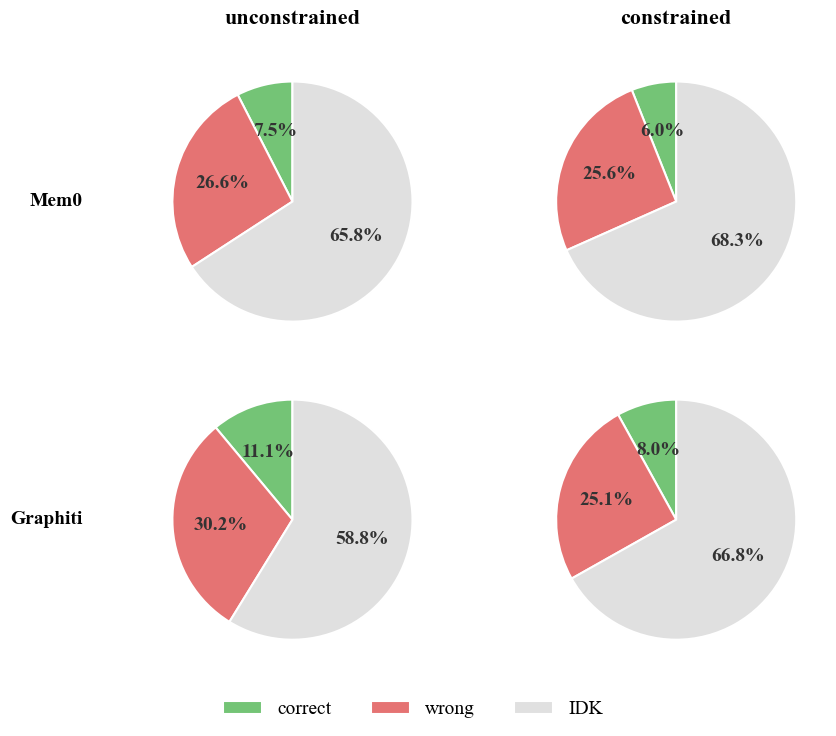

In [235]:
# --- Paper Figure Style Configuration ---
systems = ['Mem0', 'Graphiti']  # Capitalized as in the table indexes
profiles = ['unconstrained', 'constrained']
labels = ['correct', 'wrong', "IDK"]

# Professional color palette
colors = ['#74c476', '#e57373', '#e0e0e0']

# Map experiment profiles to corresponding retention tables
retention_tables = {
    'unconstrained': retention_table_unconstrained_qa,
    'constrained': retention_table_constrained_qa
}

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

wedges = None  # To store wedges for the legend

for i, system in enumerate(systems):
    for j, profile in enumerate(profiles):
        ax = axes[i, j]
        
        # Extract processed data from the appropriate table
        table = retention_tables[profile]
        
        if system in table.index:
            row = table.loc[system]
            sizes = [
                row['Correct (N)'], 
                row['Incorrect (N)'], 
                row['I Don\'t Know (N)']
            ]
            
            # Draw the pie chart
            wedges, texts, autotexts = ax.pie(
                sizes, 
                labels=None,
                autopct='%1.1f%%', 
                startangle=90,
                colors=colors,
                pctdistance=0.6,
                textprops={'fontsize': 14, 'weight': 'bold', 'color': '#333333'},
                wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
                radius=1.0
            )
        
        # --- Row/Column Label Handling ---
        
        # Set COLUMN labels (only on first row)
        if i == 0:
            ax.set_title(profile, fontsize=16, fontweight='bold', pad=20)
        
        # Set ROW labels (only on first column)
        if j == 0:
            ax.text(-0.2, 0.5, system, 
                    transform=ax.transAxes, 
                    fontsize=14, fontweight='bold', 
                    rotation=0, va='center', ha='right')

# Add a single legend below the plots
fig.legend(wedges, labels, loc='lower center', ncol=3, fontsize=14, frameon=False, bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0.05, 0.08, 1, 0.95])
plt.savefig('plots/knowledge_retention_pie_charts.png', dpi=300)
plt.show()

## [2] Total Cost of Ownership (TCO) / Cost of Execution


AWS Fargate (Serverless) us-east-1 pricing Baseline (December 2025):

- Compute (vCPU): $0.04048 per vCPU-hour.

- Memory (RAM): $0.004445 per GB-hour.

- Storage (EBS gp3): $0.000109 per GB-hour (derived from $0.08/GB-month).

- Network (Data Transfer Out): $0.09 per GB.


### Plot Group by Series


In [262]:
def plot_financial_breakdown_perfection(costs_df, title_suffix=""):
    systems = ['mem0', 'graphiti']
    # metrics = ['CPU', 'RAM', 'Disk', 'Net', 'LLM', 'TOTAL']
    metrics = ['CPU', 'RAM', 'Disk', 'Net', 'LLM']
    display_labels = {'Net': 'network', 'Disk': 'disk'}
    
    color_cloud = '#4A90E2'
    color_edge  = '#F5A623'
    
    fig, ax = plt.subplots(figsize=(12, 8)) # Increased height for more padding
    
    bar_width = 0.65
    spacing_metric = 0.2
    # spacing_total = 0.45  # Extra space before the TOTAL column
    spacing_system = 1.2
    
    n_metrics = len(metrics)
    # Group width considers extra space before TOTAL (if used)
    # group_width = (n_metrics * bar_width) + ((n_metrics - 2) * spacing_metric) + spacing_total
    group_width = (n_metrics * bar_width) + ((n_metrics - 2) * spacing_metric)
    
    start_mem0 = 0
    start_graphiti = start_mem0 + group_width + spacing_system
    system_starts = [start_mem0, start_graphiti]
    
    all_xticks = []
    all_xlabels = []
    all_totals = [] # Used to set the maximum y height for the plot

    for i, sys in enumerate(systems):
        if sys not in costs_df.index: continue
        row = costs_df.loc[sys]
        
        # Data
        cloud_vals = [row.get(f'cost_{m.lower()}_cloud', 0) for m in metrics]  # No slicing
        # cloud_vals = [row.get(f'cost_{m.lower()}_cloud', 0) for m in metrics[:-1]]
        # cloud_vals.append(sum([row[c] for c in costs_df.columns if 'cloud' in c]))
        
        edge_vals = [row.get(f'cost_{m.lower()}_edge', 0) for m in metrics]  # No slicing
        # edge_vals = [row.get(f'cost_{m.lower()}_edge', 0) for m in metrics[:-1]]
        # edge_vals.append(sum([row[c] for c in costs_df.columns if 'edge' in c]))
        
        total_vals = np.array(cloud_vals) + np.array(edge_vals)
        all_totals.extend(total_vals)
        
        # X positions - with possible extra space before TOTAL column
        current_start = system_starts[i]
        # X positions - no extra for TOTAL here
        positions = [current_start + j * (bar_width + spacing_metric) for j in range(n_metrics)]
        # positions = []
        # for j in range(n_metrics):
        #     if j < n_metrics - 1:  # Standard metrics (CPU, RAM, Disk, Net, LLM)
        #         positions.append(current_start + j * (bar_width + spacing_metric))
        #     else:  # TOTAL - add extra space
        #         positions.append(current_start + (j - 1) * (bar_width + spacing_metric) + bar_width + spacing_total)
        
        # --- BAR PLOTTING ---
        ax.bar(positions, cloud_vals, bar_width, color=color_cloud, edgecolor='white', linewidth=0.5, label='Cloud' if i==0 else "", zorder=3)
        ax.bar(positions, edge_vals, bar_width, bottom=cloud_vals, color=color_edge, edgecolor='white', linewidth=0.5, label='Edge' if i==0 else "", zorder=3)
        
        # --- Value Annotations (Above bars) ---
        for pos, val in zip(positions, total_vals):
            # Always show, even tiny values
            # If very small (< $0.01), use more decimals
            if val < 0.01 and val > 0:
                text_label = f"${val:.4f}" # 4 decimals for micro-costs (Disk)
            elif val == 0:
                text_label = "$0"
            else:
                text_label = f"${val:.2f}"
            
            # Bold for TOTAL (here would be last bar if present)
            fw = 'bold' if pos == positions[-1] else 'normal'
            # Font size: use a bit smaller if the label is long
            fs = 9 if len(text_label) > 6 else 10
            
            ax.text(pos, val * 1.15, text_label, ha='center', va='bottom', fontsize=fs, fontweight=fw, color='#333')

        # --- Group label at the top ---
        group_center = positions[0] + (positions[-1] - positions[0]) / 2
        # y=1.00 is very top; use 1.02 to go slightly above (just below plot title)
        label = sys.capitalize() if sys.lower() == "graphiti" else sys
        ax.text(group_center, 0.90, label, transform=ax.get_xaxis_transform(),
                ha='center', va='bottom', fontsize=16, fontweight='bold', color='#222')
        
        all_xticks.extend(positions)
        # all_xlabels.extend(metrics)
        all_xlabels.extend([display_labels.get(m, m) for m in metrics])

    # --- Y-AXIS FORMATTING (skip very small tick values) ---
    def currency_formatter(x, pos):
        if x == 0: 
            return "$0"
        if abs(x) < 0.001:
            return ""  # Do not show ticks below $0.001
        if abs(x) < 0.01:
            return f"${x:.3f}"
        if abs(x) < 1:
            return f"${x:.2f}"
        if abs(x) < 10000:
            return f"${int(x)}"
        return f"${x:.0e}"

    # --- AXIS STYLING ---
    ax.set_yscale('symlog', linthresh=0.001)  # Linear region up to 0.001
    
    # Manual y-ticks: jumps from 0 to 0.001, then logarithmic scaling
    ax.set_yticks([0, 0.001, 0.01, 0.1, 1, 10])
    ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    
    # Headroom: multiply the max y by 10 to add space above bars in log scale
    y_max_limit = max(all_totals) * 10 
    ax.set_ylim(0, y_max_limit)
    
    ax.grid(axis='y', linestyle='-', alpha=0.15, color='black', zorder=0)
    
    # Increase the title pad for more space from group labels
    # ax.set_title(f'Infrastructure Cost Breakdown {title_suffix}', fontsize=18, fontweight='bold', pad=45)
    
    # Y axis label: bold and clearly visible
    ax.set_ylabel('USD', fontsize=16, fontweight='bold', color='black', labelpad=10)
    ax.set_xlabel('metric', fontsize=16, fontweight='bold', color='black', labelpad=10)
    
    ax.set_xticks(all_xticks)
    ax.set_xticklabels(all_xlabels, fontsize=11, color='#444')
    
    # Remove top/right borders; lighten left/bottom borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCC')
    ax.spines['bottom'].set_color('#CCC')

    # Legend
    legend_elements = [
        Patch(facecolor=color_cloud, label='cloud cost'),
        Patch(facecolor=color_edge, label='edge cost'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', frameon=False, fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'plots/financial_breakdown_perfect_{title_suffix.lower().strip("()").replace(" ", "_")}.png', dpi=300)
    plt.show()

In [252]:
# =============================================================================
# PREPARE DATA FOR PLOTTING FROM infra_summary_mc
# =============================================================================

def extract_plot_data_from_infra_mc(infra_mc_df, constraint):
    """
    Extract plot-ready DataFrame from infra_summary_mc for a specific constraint.
    Aggregates Session Loading + Q&A and converts from millicents to USD.
    
    Args:
        infra_mc_df: infra_summary_mc DataFrame
        constraint: "Unconstrained" or "Constrained"
    
    Returns:
        DataFrame indexed by system (lowercase) with cost_X_cloud/edge columns in USD
    """
    # Filter by constraint and aggregate by System (sum Session Loading + Q&A)
    filtered = infra_mc_df.loc[constraint].groupby("System").sum()
    
    # Convert millicents to USD (divide by 1000)
    filtered = filtered / 1000
    
    # Build result DataFrame with expected column format
    result = pd.DataFrame(index=[s.lower() for s in filtered.index])
    
    result['cost_cpu_cloud'] = filtered[("Cloud", "CPU")].values
    result['cost_ram_cloud'] = filtered[("Cloud", "RAM")].values
    result['cost_disk_cloud'] = filtered[("Cloud", "Disk")].values
    result['cost_net_cloud'] = filtered[("Cloud", "Net")].values
    result['cost_llm_cloud'] = filtered[("Cloud", "LLM")].values
    result['cost_cpu_edge'] = filtered[("Edge", "CPU")].values
    result['cost_ram_edge'] = filtered[("Edge", "RAM")].values
    result['cost_disk_edge'] = filtered[("Edge", "Disk")].values
    result['cost_net_edge'] = filtered[("Edge", "Net")].values
    result['cost_llm_edge'] = 0.0  # LLM is always cloud
    
    return result

# Extract plot data from infra_summary_mc (single source of truth)
costs_unconstrained_combined_df = extract_plot_data_from_infra_mc(infra_summary_mc, "Unconstrained")
costs_constrained_combined_df = extract_plot_data_from_infra_mc(infra_summary_mc, "Constrained")

# Verify the data
print("=== UNCONSTRAINED (USD) ===")
display(costs_unconstrained_combined_df)
print("\n=== CONSTRAINED (USD) ===")
display(costs_constrained_combined_df)

=== UNCONSTRAINED (USD) ===


,cost_cpu_cloud,cost_ram_cloud,cost_disk_cloud,cost_net_cloud,cost_llm_cloud,cost_cpu_edge,cost_ram_edge,cost_disk_edge,cost_net_edge,cost_llm_edge
graphiti,0.01291,0.01867,0.0,0.12566,0.4314,0.00894,0.01139,0.0,0.00642,0.0
mem0,0.00635,0.00465,0.0,0.00196,0.4141,0.00267,0.00913,0.0,0.00016,0.0



=== CONSTRAINED (USD) ===


,cost_cpu_cloud,cost_ram_cloud,cost_disk_cloud,cost_net_cloud,cost_llm_cloud,cost_cpu_edge,cost_ram_edge,cost_disk_edge,cost_net_edge,cost_llm_edge
graphiti,0.01207,0.02037,0.0,0.11748,0.2805,0.00696,0.01395,0.0,0.00773,0.0
mem0,0.00680,0.00494,0.0,0.00219,0.4125,0.00383,0.00988,0.0,0.00018,0.0


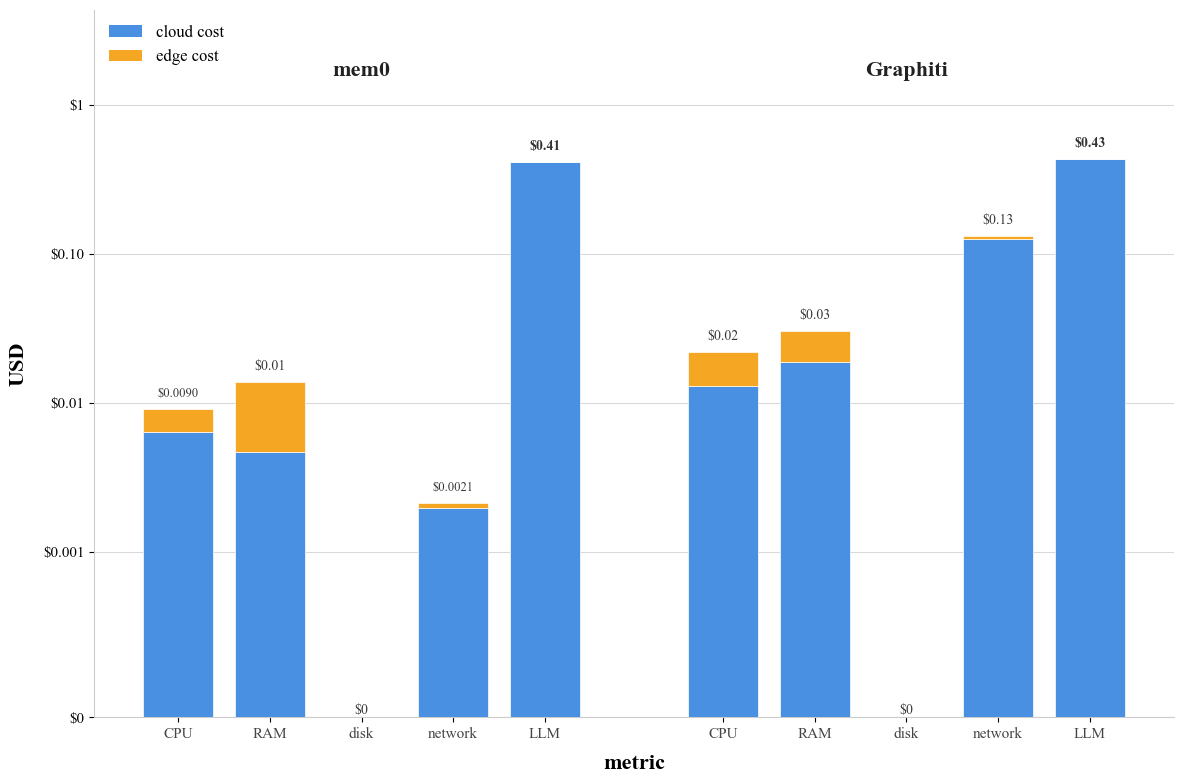

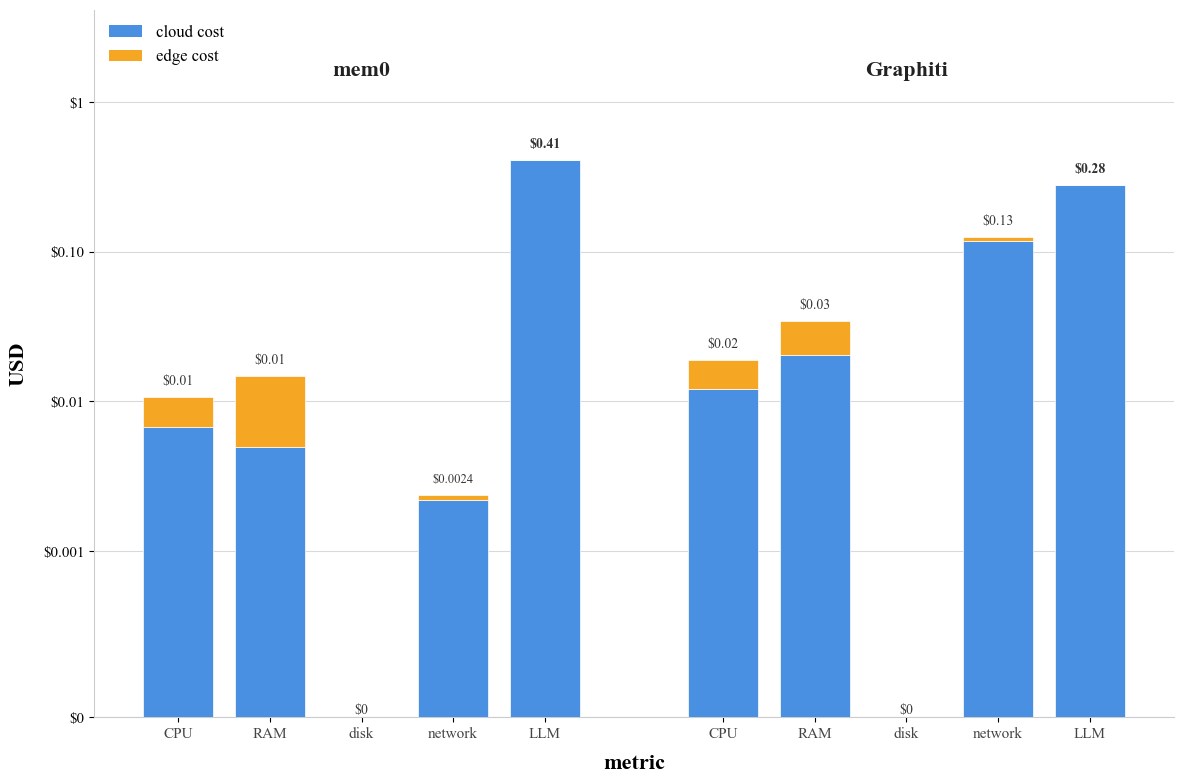

In [263]:
# Plot combined (Sessions + Q&A)
plot_financial_breakdown_perfection(costs_unconstrained_combined_df, title_suffix="(Unconstrained)")
plot_financial_breakdown_perfection(costs_constrained_combined_df, title_suffix="(Constrained)")

In [228]:
def calculate_dynamic_tco_efficiency(retention_df, latency_df, resources_df, financial_df):
    """
    Calculate economic efficiency by combining accuracy, latency, and real costs.
    
    Args:
        retention_df: DataFrame containing answer counts per system and constraint
        latency_df: DataFrame containing total time (in minutes) per system and constraint
        resources_df: DataFrame with cost columns (cost_xxx_cloud/edge, in USD)
        financial_df: Aggregated financial DataFrame (not used explicitly here)
    
    Returns:
        pd.DataFrame: Summary with correct answers, duration, costs, and efficiency metrics
    """

    # --- A. DATA PREPARATION ---

    # 1. Retention: extract only "Correct" count
    ret = retention_df.copy()
    ret.index.names = ["Constraint", "System"]
    correct_counts = ret[("Counts", "Correct")]

    # 2. Latency: aggregate Phase (sum Total Time if multi-index)
    lat = latency_df.copy()
    if lat.index.nlevels == 3:
        lat = lat.groupby(level=["Constraint", "System"])["Total Time (min)"].sum()
    else:
        lat = lat["Total Time (min)"]

    # 3. Resources: ensure correct index names
    res = resources_df.copy()
    if res.index.names != ["Constraint", "System"]:
        res.index.names = ["Constraint", "System"]

    # --- B. COST CALCULATION (separating LLM and Infra) ---

    # Separate LLM costs from infrastructure costs
    llm_columns = [c for c in res.columns if 'llm' in c]
    infra_columns = [c for c in res.columns if c.startswith('cost_') and 'llm' not in c]

    token_cost = res[llm_columns].sum(axis=1)      # Only LLM costs
    infra_cost = res[infra_columns].sum(axis=1)    # CPU, RAM, Disk, Net
    total_tco = token_cost + infra_cost            # Total cost of ownership

    # --- C. SUMMARY BUILD ---
    summary = pd.DataFrame({
        "Correct Answers": correct_counts,
        "Total Duration (min)": lat,
        "Token Cost ($)": token_cost,
        "Infra Cost ($)": infra_cost,
        "Total TCO ($)": total_tco
    })

    # Calculate efficiency metrics
    summary["Cost per Answer ($)"] = summary["Total TCO ($)"] / summary["Correct Answers"]
    summary["Answers per $1"] = summary["Correct Answers"] / summary["Total TCO ($)"]

    return summary.round(4)

# Combine costs_unconstrained_combined_df and costs_constrained_combined_df into cost_combined

# Add Constraint column and concatenate
costs_unconstrained_temp = costs_unconstrained_combined_df.copy()
costs_unconstrained_temp["Constraint"] = "Unconstrained"

costs_constrained_temp = costs_constrained_combined_df.copy()
costs_constrained_temp["Constraint"] = "Constrained"

cost_combined = pd.concat([costs_unconstrained_temp, costs_constrained_temp])
cost_combined = cost_combined.reset_index().rename(columns={"index": "System"})
cost_combined["System"] = cost_combined["System"].str.capitalize()
cost_combined = cost_combined.set_index(["Constraint", "System"])

# === EXECUTION ===
df_efficiency_final = calculate_dynamic_tco_efficiency(
    retention_df=retention_summary_multi,
    latency_df=df_latency_full,
    resources_df=cost_combined,
    financial_df=financial_summary_aggregated
)

constraint_order = ["Unconstrained", "Constrained"]
system_order = ["Graphiti", "Mem0"]

df_efficiency_final = df_efficiency_final.reindex(
    pd.MultiIndex.from_product([constraint_order, system_order], names=["Constraint", "System"])
)

display(df_efficiency_final)

Correct Answers  Total Duration (min)  Token Cost ($)  \
Constraint    System                                                            
Unconstrained Graphiti               22                234.09          0.4314   
              Mem0                   15                 70.23          0.4141   
Constrained   Graphiti               16                229.98          0.2805   
              Mem0                   12                 77.91          0.4125   

                        Infra Cost ($)  Total TCO ($)  Cost per Answer ($)  \
Constraint    System                                                         
Unconstrained Graphiti          0.1840         0.6154               0.0280   
              Mem0              0.0249         0.4390               0.0293   
Constrained   Graphiti          0.1786         0.4591               0.0287   
              Mem0              0.0278         0.4403               0.0367   

                        Answers per $1  
Constraint    System                    
Unconstrained Graphiti         35.7497  
              Mem0             34.1670  
Constrained   Graphiti         34.8538  
              Mem0             27.2529

---
